In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        self.batch_threshold = 64
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        label_rp = N
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Avoid CUDA OOM
        if N > self.batch_threshold:
            unit = (N - self.batch_threshold) // 2
            label_rp = self.batch_threshold
            if N % 2 == 0:
                source = source[unit : -unit]
            else:
                source = source[unit : -(unit + 1)]
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).repeat(label_rp)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 1000

# Hyper-parameters for training 
birdclef_batch = 1
birdclef_epoch = 30

# Learning Rate.
learning_rate_2 = 0.0005

# L2 Regularization Hyperparamter
weight_decay_2 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'log_scores': log_scores,
            'fbeta_scores': fbeta_scores,
            }, './bird_specificator.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch, ckpt_enable=True):
    val_losses = []
    train_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if ckpt_enable and os.path.exists('./bird_specificator.pt'):
        ckpt = torch.load('./bird_specificator.pt')
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        train_losses = ckpt['train_losses']
        val_losses = ckpt['val_losses']
        log_scores = ckpt['log_scores']
        fbeta_scores = ckpt['fbeta_scores']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e <= saved_epoch:
            continue
            
        epoch_losses = []
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)
        
        # every epoch, save the model
        checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, e)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_2, weight_decay=weight_decay_2, momentum=0.5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=5e-6)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                              | 3/37724 [00:03<8:25:59,  1.24it/s]

Iteration 0, loss = 6.1403


  3%|██                                                                           | 1002/37724 [01:23<41:26, 14.77it/s]

Iteration 1000, loss = 5.6271


  5%|████                                                                         | 2002/37724 [02:40<35:36, 16.72it/s]

Iteration 2000, loss = 5.6788


  8%|██████▏                                                                      | 3004/37724 [04:01<38:11, 15.15it/s]

Iteration 3000, loss = 5.4855


 11%|████████▏                                                                    | 4003/37724 [05:18<40:02, 14.03it/s]

Iteration 4000, loss = 6.7990


 13%|██████████▏                                                                  | 5001/37724 [06:32<35:03, 15.56it/s]

Iteration 5000, loss = 6.8256


 16%|████████████▎                                                                | 6002/37724 [07:52<42:52, 12.33it/s]

Iteration 6000, loss = 5.6216


 19%|██████████████▎                                                              | 7002/37724 [09:10<30:35, 16.74it/s]

Iteration 7000, loss = 5.0921


 21%|████████████████▎                                                            | 8004/37724 [10:30<32:42, 15.14it/s]

Iteration 8000, loss = 6.3985


 24%|██████████████████▎                                                          | 9002/37724 [11:51<36:07, 13.25it/s]

Iteration 9000, loss = 6.8218


 27%|████████████████████▏                                                       | 10004/37724 [13:10<29:56, 15.43it/s]

Iteration 10000, loss = 5.2617


 29%|██████████████████████▏                                                     | 11002/37724 [14:28<43:39, 10.20it/s]

Iteration 11000, loss = 4.9789


 32%|████████████████████████▏                                                   | 12002/37724 [15:46<28:51, 14.85it/s]

Iteration 12000, loss = 6.1648


 34%|██████████████████████████▏                                                 | 13003/37724 [17:05<44:20,  9.29it/s]

Iteration 13000, loss = 5.8748


 37%|████████████████████████████▏                                               | 14002/37724 [18:22<26:22, 14.99it/s]

Iteration 14000, loss = 5.9463


 40%|██████████████████████████████▏                                             | 15003/37724 [19:39<25:04, 15.10it/s]

Iteration 15000, loss = 5.8141


 42%|████████████████████████████████▏                                           | 16002/37724 [21:00<27:04, 13.37it/s]

Iteration 16000, loss = 6.7943


 45%|██████████████████████████████████▎                                         | 17003/37724 [22:17<25:06, 13.75it/s]

Iteration 17000, loss = 6.2380


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:37<22:20, 14.72it/s]

Iteration 18000, loss = 7.0301


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:59<30:07, 10.36it/s]

Iteration 19000, loss = 6.5512


 53%|████████████████████████████████████████▎                                   | 20003/37724 [26:17<24:05, 12.26it/s]

Iteration 20000, loss = 5.8807


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [27:40<17:50, 15.63it/s]

Iteration 21000, loss = 6.3241


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:56<15:57, 16.41it/s]

Iteration 22000, loss = 5.6153


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [30:17<16:23, 14.97it/s]

Iteration 23000, loss = 6.1783


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [31:38<20:12, 11.32it/s]

Iteration 24000, loss = 5.4110


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [32:56<12:48, 16.56it/s]

Iteration 25000, loss = 6.3337


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [34:14<12:14, 15.95it/s]

Iteration 26000, loss = 5.6318


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [35:33<12:37, 14.15it/s]

Iteration 27000, loss = 5.7506


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [36:50<10:32, 15.37it/s]

Iteration 28000, loss = 5.6676


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [38:08<09:08, 15.89it/s]

Iteration 29000, loss = 6.2228


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [39:26<10:44, 11.98it/s]

Iteration 30000, loss = 5.9560


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [40:44<05:46, 19.38it/s]

Iteration 31000, loss = 5.9458


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [42:03<10:13,  9.33it/s]

Iteration 32000, loss = 5.0619


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [43:25<05:46, 13.63it/s]

Iteration 33000, loss = 5.2405


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [44:45<04:28, 13.87it/s]

Iteration 34000, loss = 6.3531


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [46:01<04:35,  9.86it/s]

Iteration 35000, loss = 6.4207


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [47:23<02:07, 13.46it/s]

Iteration 36000, loss = 6.7682


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [48:38<01:00, 11.91it/s]

Iteration 37000, loss = 5.7404


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [49:39<00:00, 12.66it/s]


Checking accuracy score on validation set.

Accuracy: 2892 / 131159 correct (2.20)
Log Loss score:	5.64
Fbeta-score (beta=1): 	0.02
Training model 2, epoch 2


  0%|                                                                              | 1/37724 [00:00<1:04:06,  9.81it/s]

Iteration 0, loss = 5.9843


  3%|██                                                                           | 1004/37724 [01:15<36:01, 16.99it/s]

Iteration 1000, loss = 6.3995


  5%|████                                                                         | 2004/37724 [02:32<48:56, 12.17it/s]

Iteration 2000, loss = 7.0575


  8%|██████▏                                                                      | 3002/37724 [03:46<42:30, 13.61it/s]

Iteration 3000, loss = 5.9330


 11%|████████▏                                                                    | 4002/37724 [05:03<37:39, 14.92it/s]

Iteration 4000, loss = 6.2506


 13%|██████████▏                                                                  | 5002/37724 [06:19<44:58, 12.12it/s]

Iteration 5000, loss = 6.8228


 16%|████████████▎                                                                | 6003/37724 [07:37<47:26, 11.14it/s]

Iteration 6000, loss = 6.2005


 19%|██████████████▎                                                              | 7004/37724 [08:52<36:03, 14.20it/s]

Iteration 7000, loss = 5.9600


 21%|████████████████▎                                                            | 8003/37724 [10:08<32:12, 15.38it/s]

Iteration 8000, loss = 6.4481


 24%|██████████████████▎                                                          | 9002/37724 [11:28<37:24, 12.80it/s]

Iteration 9000, loss = 6.7340


 27%|████████████████████▏                                                       | 10004/37724 [12:43<31:43, 14.56it/s]

Iteration 10000, loss = 4.4247


 29%|██████████████████████▏                                                     | 10999/37724 [13:57<40:35, 10.97it/s]

Iteration 11000, loss = 4.1679


 32%|████████████████████████▏                                                   | 12000/37724 [15:17<29:04, 14.74it/s]

Iteration 12000, loss = 4.7415


 34%|██████████████████████████▏                                                 | 13003/37724 [16:33<30:59, 13.29it/s]

Iteration 13000, loss = 6.6220


 37%|████████████████████████████▏                                               | 14002/37724 [17:47<33:26, 11.82it/s]

Iteration 14000, loss = 5.5513


 40%|██████████████████████████████▏                                             | 15003/37724 [19:04<25:31, 14.84it/s]

Iteration 15000, loss = 6.0203


 42%|████████████████████████████████▏                                           | 16003/37724 [20:20<22:09, 16.34it/s]

Iteration 16000, loss = 5.3471


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:34<21:05, 16.37it/s]

Iteration 17000, loss = 4.5095


 48%|████████████████████████████████████▎                                       | 18004/37724 [22:53<23:37, 13.91it/s]

Iteration 18000, loss = 5.1541


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:07<24:09, 12.92it/s]

Iteration 19000, loss = 4.2876


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:21<26:14, 11.26it/s]

Iteration 20000, loss = 3.7826


 56%|██████████████████████████████████████████▎                                 | 21000/37724 [26:33<20:29, 13.61it/s]

Iteration 21000, loss = 5.3642


 58%|████████████████████████████████████████████▎                               | 22001/37724 [27:50<17:50, 14.69it/s]

Iteration 22000, loss = 3.4102


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:07<18:59, 12.92it/s]

Iteration 23000, loss = 6.7887


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:27<15:44, 14.52it/s]

Iteration 24000, loss = 6.6041


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:44<14:34, 14.55it/s]

Iteration 25000, loss = 3.3053


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:00<15:24, 12.67it/s]

Iteration 26000, loss = 4.4861


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:19<16:45, 10.66it/s]

Iteration 27000, loss = 4.4904


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:41<12:45, 12.69it/s]

Iteration 28000, loss = 1.6120


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [36:58<09:14, 15.72it/s]

Iteration 29000, loss = 4.7269


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:15<07:31, 17.10it/s]

Iteration 30000, loss = 3.5586


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:32<10:44, 10.43it/s]

Iteration 31000, loss = 5.3770


 85%|████████████████████████████████████████████████████████████████▍           | 32005/37724 [40:46<05:45, 16.57it/s]

Iteration 32000, loss = 4.5549


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:02<04:22, 17.96it/s]

Iteration 33000, loss = 1.0926


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:15<04:40, 13.25it/s]

Iteration 34000, loss = 4.9759


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:33<03:13, 14.04it/s]

Iteration 35000, loss = 4.5390


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:49<01:31, 18.76it/s]

Iteration 36000, loss = 4.5567


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:01<01:08, 10.60it/s]

Iteration 37000, loss = 3.0231


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:57<00:00, 13.11it/s]


Checking accuracy score on validation set.

Accuracy: 32078 / 131159 correct (24.46)
Log Loss score:	3.73
Fbeta-score (beta=1): 	0.24
Training model 2, epoch 3


  0%|                                                                                | 3/37724 [00:00<28:42, 21.90it/s]

Iteration 0, loss = 3.0285


  3%|██                                                                           | 1003/37724 [01:18<44:55, 13.62it/s]

Iteration 1000, loss = 3.0998


  5%|████                                                                         | 2004/37724 [02:35<32:23, 18.38it/s]

Iteration 2000, loss = 3.4835


  8%|██████▏                                                                      | 3001/37724 [03:51<56:35, 10.23it/s]

Iteration 3000, loss = 3.7713


 11%|████████▏                                                                    | 4002/37724 [05:06<41:57, 13.40it/s]

Iteration 4000, loss = 5.6721


 13%|██████████▏                                                                  | 5003/37724 [06:27<38:41, 14.10it/s]

Iteration 5000, loss = 0.9365


 16%|████████████▎                                                                | 6003/37724 [07:40<35:26, 14.92it/s]

Iteration 6000, loss = 2.4381


 19%|██████████████▎                                                              | 7002/37724 [08:56<32:41, 15.66it/s]

Iteration 7000, loss = 4.3012


 21%|████████████████▎                                                            | 8004/37724 [10:15<29:57, 16.54it/s]

Iteration 8000, loss = 5.7716


 24%|██████████████████▍                                                          | 9005/37724 [11:31<32:16, 14.83it/s]

Iteration 9000, loss = 5.4645


 27%|████████████████████▏                                                       | 10002/37724 [12:44<28:01, 16.49it/s]

Iteration 10000, loss = 2.6609


 29%|██████████████████████▏                                                     | 11004/37724 [14:03<31:54, 13.96it/s]

Iteration 11000, loss = 2.5311


 32%|████████████████████████▏                                                   | 12002/37724 [15:20<42:22, 10.12it/s]

Iteration 12000, loss = 2.8826


 34%|██████████████████████████▏                                                 | 13004/37724 [16:36<37:00, 11.14it/s]

Iteration 13000, loss = 10.4003


 37%|████████████████████████████▏                                               | 14004/37724 [17:54<25:18, 15.62it/s]

Iteration 14000, loss = 1.3881


 40%|██████████████████████████████▏                                             | 15003/37724 [19:13<24:35, 15.40it/s]

Iteration 15000, loss = 4.9479


 42%|████████████████████████████████▏                                           | 16002/37724 [20:28<22:53, 15.82it/s]

Iteration 16000, loss = 5.0797


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:42<28:43, 12.02it/s]

Iteration 17000, loss = 0.0289


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:58<23:28, 14.00it/s]

Iteration 18000, loss = 2.8700


 50%|██████████████████████████████████████▎                                     | 19004/37724 [24:13<22:54, 13.62it/s]

Iteration 19000, loss = 4.8936


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:31<30:14,  9.77it/s]

Iteration 20000, loss = 1.1662


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:48<18:15, 15.26it/s]

Iteration 21000, loss = 7.4838


 58%|████████████████████████████████████████████▎                               | 22005/37724 [28:03<22:17, 11.76it/s]

Iteration 22000, loss = 6.0810


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:16<14:01, 17.49it/s]

Iteration 23000, loss = 0.8974


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:32<28:01,  8.16it/s]

Iteration 24000, loss = 3.8270


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:49<15:36, 13.58it/s]

Iteration 25000, loss = 2.3356


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:03<13:43, 14.24it/s]

Iteration 26000, loss = 1.9297


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:20<16:15, 10.99it/s]

Iteration 27000, loss = 7.9799


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:37<11:07, 14.57it/s]

Iteration 28000, loss = 1.1827


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:51<14:17, 10.17it/s]

Iteration 29000, loss = 2.5132


 80%|████████████████████████████████████████████████████████████▍               | 30005/37724 [38:07<07:46, 16.55it/s]

Iteration 30000, loss = 3.3445


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:22<07:44, 14.47it/s]

Iteration 31000, loss = 1.8148


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:38<05:58, 15.97it/s]

Iteration 32000, loss = 0.2387


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [41:58<05:31, 14.23it/s]

Iteration 33000, loss = 0.9338


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:13<03:35, 17.28it/s]

Iteration 34000, loss = 7.4052


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:25<03:07, 14.50it/s]

Iteration 35000, loss = 0.1935


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:43<01:24, 20.46it/s]

Iteration 36000, loss = 3.6272


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [46:59<00:39, 18.45it/s]

Iteration 37000, loss = 0.7210


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:52<00:00, 13.13it/s]


Checking accuracy score on validation set.

Accuracy: 46095 / 131159 correct (35.14)
Log Loss score:	3.13
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 4


  0%|                                                                              | 1/37724 [00:00<1:08:31,  9.17it/s]

Iteration 0, loss = 2.6770


  3%|██                                                                           | 1003/37724 [01:15<36:04, 16.97it/s]

Iteration 1000, loss = 5.7520


  5%|████                                                                         | 2004/37724 [02:31<36:31, 16.30it/s]

Iteration 2000, loss = 3.5470


  8%|██████▏                                                                      | 3002/37724 [03:50<46:52, 12.34it/s]

Iteration 3000, loss = 1.8642


 11%|████████▏                                                                    | 4005/37724 [05:05<27:19, 20.57it/s]

Iteration 4000, loss = 5.9053


 13%|██████████▏                                                                  | 5003/37724 [06:18<30:17, 18.00it/s]

Iteration 5000, loss = 1.9562


 16%|████████████▎                                                                | 6005/37724 [07:35<29:38, 17.84it/s]

Iteration 6000, loss = 2.2873


 19%|██████████████▎                                                              | 7003/37724 [08:49<39:10, 13.07it/s]

Iteration 7000, loss = 3.9157


 21%|████████████████▎                                                            | 8003/37724 [10:06<37:04, 13.36it/s]

Iteration 8000, loss = 2.4670


 24%|██████████████████▎                                                          | 9001/37724 [11:23<34:25, 13.90it/s]

Iteration 9000, loss = 0.4687


 27%|████████████████████▏                                                       | 10003/37724 [12:37<32:30, 14.21it/s]

Iteration 10000, loss = 3.2441


 29%|██████████████████████▏                                                     | 11002/37724 [13:49<41:27, 10.74it/s]

Iteration 11000, loss = 3.6326


 32%|████████████████████████▏                                                   | 12003/37724 [15:07<27:12, 15.76it/s]

Iteration 12000, loss = 3.7138


 34%|██████████████████████████▏                                                 | 13001/37724 [16:26<32:04, 12.85it/s]

Iteration 13000, loss = 5.0382


 37%|████████████████████████████▏                                               | 14003/37724 [17:43<26:18, 15.03it/s]

Iteration 14000, loss = 4.9141


 40%|██████████████████████████████▏                                             | 15001/37724 [18:57<38:33,  9.82it/s]

Iteration 15000, loss = 3.2431


 42%|████████████████████████████████▏                                           | 16002/37724 [20:15<29:16, 12.37it/s]

Iteration 16000, loss = 3.5091


 45%|██████████████████████████████████▎                                         | 17001/37724 [21:34<22:10, 15.57it/s]

Iteration 17000, loss = 5.2076


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:52<30:37, 10.74it/s]

Iteration 18000, loss = 0.8437


 50%|██████████████████████████████████████▎                                     | 19005/37724 [24:07<26:13, 11.89it/s]

Iteration 19000, loss = 1.2912


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:21<20:46, 14.22it/s]

Iteration 20000, loss = 2.2203


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:37<22:49, 12.21it/s]

Iteration 21000, loss = 0.0297


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:57<16:50, 15.56it/s]

Iteration 22000, loss = 0.1280


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:14<15:32, 15.79it/s]

Iteration 23000, loss = 5.0568


 64%|████████████████████████████████████████████████▎                           | 24004/37724 [30:31<12:16, 18.64it/s]

Iteration 24000, loss = 0.8588


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:48<12:51, 16.48it/s]

Iteration 25000, loss = 4.2429


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:06<12:28, 15.66it/s]

Iteration 26000, loss = 0.5004


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:23<10:38, 16.80it/s]

Iteration 27000, loss = 2.0867


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:41<17:09,  9.45it/s]

Iteration 28000, loss = 5.4172


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:02<10:31, 13.81it/s]

Iteration 29000, loss = 0.8710


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:24<11:40, 11.03it/s]

Iteration 30000, loss = 2.7176


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:43<07:04, 15.83it/s]

Iteration 31000, loss = 0.6729


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [41:01<07:49, 12.17it/s]

Iteration 32000, loss = 0.2458


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:16<04:54, 16.01it/s]

Iteration 33000, loss = 7.0345


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:34<03:58, 15.60it/s]

Iteration 34000, loss = 1.6561


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:52<02:39, 17.05it/s]

Iteration 35000, loss = 4.1781


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [46:08<02:02, 14.04it/s]

Iteration 36000, loss = 0.0003


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:24<00:42, 16.84it/s]

Iteration 37000, loss = 1.7549


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:20<00:00, 13.00it/s]


Checking accuracy score on validation set.

Accuracy: 54909 / 131159 correct (41.86)
Log Loss score:	2.82
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 5


  0%|                                                                              | 1/37724 [00:00<1:44:58,  5.99it/s]

Iteration 0, loss = 1.8043


  3%|██                                                                           | 1004/37724 [01:16<35:07, 17.42it/s]

Iteration 1000, loss = 0.0029


  5%|████                                                                         | 2004/37724 [02:33<50:42, 11.74it/s]

Iteration 2000, loss = 5.3664


  8%|██████▏                                                                      | 3004/37724 [03:50<39:57, 14.48it/s]

Iteration 3000, loss = 4.2724


 11%|████████▏                                                                    | 4002/37724 [05:02<39:00, 14.41it/s]

Iteration 4000, loss = 0.7124


 13%|██████████▏                                                                  | 4999/37724 [06:20<42:35, 12.81it/s]

Iteration 5000, loss = 4.7838


 16%|████████████▎                                                                | 6002/37724 [07:37<43:03, 12.28it/s]

Iteration 6000, loss = 2.4755


 19%|██████████████▎                                                              | 7005/37724 [08:51<30:26, 16.82it/s]

Iteration 7000, loss = 3.2826


 21%|████████████████▎                                                            | 8005/37724 [10:07<33:39, 14.71it/s]

Iteration 8000, loss = 6.6915


 24%|██████████████████▎                                                          | 9002/37724 [11:23<38:05, 12.56it/s]

Iteration 9000, loss = 1.7684


 27%|████████████████████▏                                                       | 10003/37724 [12:40<30:18, 15.24it/s]

Iteration 10000, loss = 5.3151


 29%|██████████████████████▏                                                     | 11003/37724 [13:58<35:50, 12.43it/s]

Iteration 11000, loss = 0.4899


 32%|████████████████████████▏                                                   | 12002/37724 [15:15<34:52, 12.29it/s]

Iteration 12000, loss = 0.6705


 34%|██████████████████████████▏                                                 | 13002/37724 [16:32<29:58, 13.74it/s]

Iteration 13000, loss = 0.4742


 37%|████████████████████████████▏                                               | 14004/37724 [17:49<24:06, 16.40it/s]

Iteration 14000, loss = 1.6319


 40%|██████████████████████████████▏                                             | 15003/37724 [19:05<21:28, 17.64it/s]

Iteration 15000, loss = 0.2872


 42%|████████████████████████████████▏                                           | 16003/37724 [20:22<20:33, 17.60it/s]

Iteration 16000, loss = 0.0163


 45%|██████████████████████████████████▎                                         | 17005/37724 [21:43<22:36, 15.28it/s]

Iteration 17000, loss = 2.0600


 48%|████████████████████████████████████▎                                       | 18005/37724 [22:59<21:09, 15.53it/s]

Iteration 18000, loss = 1.2517


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:13<28:48, 10.83it/s]

Iteration 19000, loss = 3.9679


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:31<22:16, 13.26it/s]

Iteration 20000, loss = 4.4227


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:49<21:52, 12.74it/s]

Iteration 21000, loss = 1.4474


 58%|████████████████████████████████████████████▎                               | 22004/37724 [28:06<18:25, 14.22it/s]

Iteration 22000, loss = 0.4423


 61%|██████████████████████████████████████████████▎                             | 23005/37724 [29:26<12:16, 19.99it/s]

Iteration 23000, loss = 0.0072


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:43<22:49, 10.02it/s]

Iteration 24000, loss = 3.2598


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:59<12:39, 16.74it/s]

Iteration 25000, loss = 5.6235


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:16<13:59, 13.96it/s]

Iteration 26000, loss = 4.9792


 72%|██████████████████████████████████████████████████████▍                     | 27000/37724 [34:31<11:49, 15.11it/s]

Iteration 27000, loss = 4.4095


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:46<15:21, 10.55it/s]

Iteration 28000, loss = 2.8172


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [37:05<08:29, 17.10it/s]

Iteration 29000, loss = 2.1893


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [38:21<07:41, 16.73it/s]

Iteration 30000, loss = 6.9013


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:41<09:30, 11.78it/s]

Iteration 31000, loss = 2.7176


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:59<07:05, 13.43it/s]

Iteration 32000, loss = 4.5500


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:16<05:07, 15.38it/s]

Iteration 33000, loss = 1.1661


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:36<04:37, 13.41it/s]

Iteration 34000, loss = 0.9491


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:53<03:13, 14.05it/s]

Iteration 35000, loss = 1.5725


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [46:13<02:01, 14.17it/s]

Iteration 36000, loss = 4.1304


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:31<01:04, 11.15it/s]

Iteration 37000, loss = 2.0701


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:30<00:00, 12.96it/s]


Checking accuracy score on validation set.

Accuracy: 61351 / 131159 correct (46.78)
Log Loss score:	2.61
Fbeta-score (beta=1): 	0.47
Training model 2, epoch 6


  0%|                                                                              | 1/37724 [00:00<1:12:16,  8.70it/s]

Iteration 0, loss = 0.0168


  3%|██                                                                           | 1003/37724 [01:16<40:54, 14.96it/s]

Iteration 1000, loss = 0.6198


  5%|████                                                                         | 2005/37724 [02:32<46:01, 12.94it/s]

Iteration 2000, loss = 1.5248


  8%|██████▏                                                                      | 3001/37724 [03:46<39:59, 14.47it/s]

Iteration 3000, loss = 2.9232


 11%|████████▏                                                                    | 4002/37724 [05:04<55:20, 10.16it/s]

Iteration 4000, loss = 1.7156


 13%|██████████▏                                                                  | 5005/37724 [06:22<30:31, 17.87it/s]

Iteration 5000, loss = 0.6068


 16%|████████████▎                                                                | 6002/37724 [07:39<37:07, 14.24it/s]

Iteration 6000, loss = 3.5610


 19%|██████████████▎                                                              | 6999/37724 [08:56<55:03,  9.30it/s]

Iteration 7000, loss = 2.4257


 21%|████████████████▎                                                            | 8003/37724 [10:15<36:02, 13.74it/s]

Iteration 8000, loss = 0.6276


 24%|██████████████████▎                                                          | 9002/37724 [11:33<42:56, 11.15it/s]

Iteration 9000, loss = 1.5843


 27%|████████████████████▏                                                       | 10005/37724 [12:53<33:27, 13.81it/s]

Iteration 10000, loss = 0.9707


 29%|██████████████████████▏                                                     | 11003/37724 [14:13<25:29, 17.47it/s]

Iteration 11000, loss = 2.2808


 32%|████████████████████████▏                                                   | 12003/37724 [15:32<31:31, 13.60it/s]

Iteration 12000, loss = 1.5531


 34%|██████████████████████████▏                                                 | 13002/37724 [16:47<24:43, 16.66it/s]

Iteration 13000, loss = 0.0522


 37%|████████████████████████████▏                                               | 14003/37724 [17:59<20:40, 19.12it/s]

Iteration 14000, loss = 0.0280


 40%|██████████████████████████████▏                                             | 15005/37724 [19:18<22:43, 16.67it/s]

Iteration 15000, loss = 0.3588


 42%|████████████████████████████████▏                                           | 16004/37724 [20:33<23:41, 15.28it/s]

Iteration 16000, loss = 0.3738


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:48<30:29, 11.33it/s]

Iteration 17000, loss = 1.5459


 48%|████████████████████████████████████▎                                       | 18004/37724 [23:05<18:24, 17.86it/s]

Iteration 18000, loss = 0.1711


 50%|██████████████████████████████████████▎                                     | 19000/37724 [24:19<29:01, 10.75it/s]

Iteration 19000, loss = 2.2781


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:35<19:28, 15.17it/s]

Iteration 20000, loss = 6.2747


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:54<18:21, 15.18it/s]

Iteration 21000, loss = 2.5712


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:12<20:13, 12.95it/s]

Iteration 22000, loss = 4.6170


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:26<15:14, 16.10it/s]

Iteration 23000, loss = 0.2334


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:40<22:48, 10.03it/s]

Iteration 24000, loss = 6.7477


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:56<17:25, 12.17it/s]

Iteration 25000, loss = 0.1751


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:13<19:30, 10.02it/s]

Iteration 26000, loss = 0.4292


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:28<13:55, 12.83it/s]

Iteration 27000, loss = 2.5425


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:44<12:10, 13.32it/s]

Iteration 28000, loss = 1.8590


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:00<09:29, 15.32it/s]

Iteration 29000, loss = 0.3503


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:17<08:31, 15.09it/s]

Iteration 30000, loss = 3.4861


 82%|██████████████████████████████████████████████████████████████▍             | 31000/37724 [39:33<07:38, 14.65it/s]

Iteration 31000, loss = 2.3027


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:49<05:57, 16.03it/s]

Iteration 32000, loss = 0.4714


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:03<06:42, 11.72it/s]

Iteration 33000, loss = 4.6524


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:22<04:39, 13.34it/s]

Iteration 34000, loss = 5.4902


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:38<02:43, 16.62it/s]

Iteration 35000, loss = 0.0169


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:54<02:13, 12.89it/s]

Iteration 36000, loss = 5.4741


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:08<00:54, 13.17it/s]

Iteration 37000, loss = 0.0535


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:05<00:00, 13.07it/s]


Checking accuracy score on validation set.

Accuracy: 65675 / 131159 correct (50.07)
Log Loss score:	2.43
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 7


  0%|                                                                              | 1/37724 [00:00<1:05:59,  9.53it/s]

Iteration 0, loss = 0.6300


  3%|██                                                                           | 1002/37724 [01:15<59:39, 10.26it/s]

Iteration 1000, loss = 0.0033


  5%|████                                                                         | 2001/37724 [02:30<38:47, 15.35it/s]

Iteration 2000, loss = 3.1989


  8%|██████▏                                                                      | 3001/37724 [03:47<53:08, 10.89it/s]

Iteration 3000, loss = 1.3028


 11%|████████▏                                                                    | 4001/37724 [05:03<32:36, 17.24it/s]

Iteration 4000, loss = 3.3428


 13%|██████████▏                                                                  | 5002/37724 [06:19<37:19, 14.61it/s]

Iteration 5000, loss = 0.7223


 16%|████████████▎                                                                | 6002/37724 [07:33<50:22, 10.50it/s]

Iteration 6000, loss = 2.8036


 19%|██████████████▎                                                              | 7004/37724 [08:52<36:07, 14.17it/s]

Iteration 7000, loss = 2.9787


 21%|████████████████▎                                                            | 8003/37724 [10:10<44:48, 11.06it/s]

Iteration 8000, loss = 1.8065


 24%|██████████████████▍                                                          | 9004/37724 [11:27<36:21, 13.17it/s]

Iteration 9000, loss = 0.6398


 27%|████████████████████▏                                                       | 10000/37724 [12:40<36:48, 12.55it/s]

Iteration 10000, loss = 1.8523


 29%|██████████████████████▏                                                     | 11003/37724 [13:55<31:36, 14.09it/s]

Iteration 11000, loss = 0.0025


 32%|████████████████████████▏                                                   | 12001/37724 [15:12<24:13, 17.69it/s]

Iteration 12000, loss = 1.1906


 34%|██████████████████████████▏                                                 | 13003/37724 [16:27<31:19, 13.15it/s]

Iteration 13000, loss = 2.0570


 37%|████████████████████████████▏                                               | 14005/37724 [17:41<21:43, 18.19it/s]

Iteration 14000, loss = 3.2069


 40%|██████████████████████████████▏                                             | 15001/37724 [18:55<24:50, 15.25it/s]

Iteration 15000, loss = 2.3658


 42%|████████████████████████████████▏                                           | 16006/37724 [20:12<19:18, 18.75it/s]

Iteration 16000, loss = 0.8037


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:27<21:57, 15.72it/s]

Iteration 17000, loss = 1.5322


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:44<22:24, 14.66it/s]

Iteration 18000, loss = 1.1208


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:02<41:15,  7.56it/s]

Iteration 19000, loss = 0.7244


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:18<20:44, 14.24it/s]

Iteration 20000, loss = 0.9206


 56%|██████████████████████████████████████████▎                                 | 21005/37724 [26:34<16:47, 16.60it/s]

Iteration 21000, loss = 0.0194


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:51<21:52, 11.98it/s]

Iteration 22000, loss = 0.7517


 61%|██████████████████████████████████████████████▎                             | 22999/37724 [29:09<23:35, 10.40it/s]

Iteration 23000, loss = 5.4776


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:25<11:15, 20.32it/s]

Iteration 24000, loss = 0.0021


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:42<15:54, 13.33it/s]

Iteration 25000, loss = 6.8827


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [32:57<12:25, 15.72it/s]

Iteration 26000, loss = 0.3581


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:15<11:43, 15.25it/s]

Iteration 27000, loss = 0.0071


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:34<18:29,  8.77it/s]

Iteration 28000, loss = 2.1454


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:49<13:15, 10.97it/s]

Iteration 29000, loss = 4.1923


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [38:05<09:59, 12.87it/s]

Iteration 30000, loss = 6.4347


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:19<08:09, 13.73it/s]

Iteration 31000, loss = 1.4024


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:36<05:32, 17.21it/s]

Iteration 32000, loss = 2.3865


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [41:54<05:41, 13.83it/s]

Iteration 33000, loss = 3.5725


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:14<04:39, 13.32it/s]

Iteration 34000, loss = 1.7985


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:33<03:27, 13.12it/s]

Iteration 35000, loss = 6.3529


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [45:51<01:40, 17.06it/s]

Iteration 36000, loss = 1.4819


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:10<00:36, 19.49it/s]

Iteration 37000, loss = 1.0368


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:04<00:00, 13.08it/s]


Checking accuracy score on validation set.

Accuracy: 66489 / 131159 correct (50.69)
Log Loss score:	2.42
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 8


  0%|                                                                              | 1/37724 [00:00<1:10:23,  8.93it/s]

Iteration 0, loss = 3.5511


  3%|██                                                                           | 1002/37724 [01:18<40:46, 15.01it/s]

Iteration 1000, loss = 2.9166


  5%|████                                                                         | 2003/37724 [02:32<43:25, 13.71it/s]

Iteration 2000, loss = 1.5710


  8%|██████▏                                                                      | 3003/37724 [03:49<38:01, 15.22it/s]

Iteration 3000, loss = 3.5258


 11%|████████▏                                                                    | 4001/37724 [05:08<43:33, 12.90it/s]

Iteration 4000, loss = 2.1981


 13%|██████████▏                                                                  | 5004/37724 [06:25<32:11, 16.94it/s]

Iteration 5000, loss = 0.0001


 16%|████████████▎                                                                | 6004/37724 [07:41<36:51, 14.34it/s]

Iteration 6000, loss = 0.4231


 19%|██████████████▎                                                              | 7002/37724 [08:58<46:39, 10.97it/s]

Iteration 7000, loss = 4.8968


 21%|████████████████▎                                                            | 8004/37724 [10:19<26:32, 18.67it/s]

Iteration 8000, loss = 1.8137


 24%|██████████████████▎                                                          | 9002/37724 [11:36<43:40, 10.96it/s]

Iteration 9000, loss = 2.2723


 27%|████████████████████▏                                                       | 10003/37724 [12:56<49:24,  9.35it/s]

Iteration 10000, loss = 2.5951


 29%|██████████████████████▏                                                     | 11002/37724 [14:14<30:33, 14.58it/s]

Iteration 11000, loss = 0.1039


 32%|████████████████████████▏                                                   | 12003/37724 [15:30<33:18, 12.87it/s]

Iteration 12000, loss = 0.8841


 34%|██████████████████████████▏                                                 | 13004/37724 [16:48<28:23, 14.51it/s]

Iteration 13000, loss = 2.3900


 37%|████████████████████████████▏                                               | 14001/37724 [18:05<36:18, 10.89it/s]

Iteration 14000, loss = 2.4037


 40%|██████████████████████████████▏                                             | 15002/37724 [19:24<26:18, 14.40it/s]

Iteration 15000, loss = 0.0007


 42%|████████████████████████████████▏                                           | 16004/37724 [20:44<25:23, 14.26it/s]

Iteration 16000, loss = 0.0165


 45%|██████████████████████████████████▎                                         | 17002/37724 [22:00<28:28, 12.13it/s]

Iteration 17000, loss = 3.7138


 48%|████████████████████████████████████▎                                       | 18002/37724 [23:17<26:47, 12.27it/s]

Iteration 18000, loss = 1.9181


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:33<25:06, 12.42it/s]

Iteration 19000, loss = 5.1070


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:54<24:39, 11.97it/s]

Iteration 20000, loss = 0.5721


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [27:10<16:08, 17.26it/s]

Iteration 21000, loss = 2.4779


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:28<19:43, 13.28it/s]

Iteration 22000, loss = 0.0058


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:46<22:00, 11.15it/s]

Iteration 23000, loss = 2.0629


 64%|████████████████████████████████████████████████▎                           | 24001/37724 [31:01<18:33, 12.33it/s]

Iteration 24000, loss = 0.2629


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [32:19<13:36, 15.58it/s]

Iteration 25000, loss = 4.4009


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:36<14:37, 13.36it/s]

Iteration 26000, loss = 0.6491


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:53<12:11, 14.65it/s]

Iteration 27000, loss = 3.3390


 74%|████████████████████████████████████████████████████████▍                   | 28001/37724 [36:10<22:00,  7.36it/s]

Iteration 28000, loss = 0.7583


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:26<11:08, 13.05it/s]

Iteration 29000, loss = 1.3096


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:42<08:48, 14.62it/s]

Iteration 30000, loss = 4.9817


 82%|██████████████████████████████████████████████████████████████▍             | 31005/37724 [40:02<07:30, 14.91it/s]

Iteration 31000, loss = 4.1347


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [41:21<07:32, 12.64it/s]

Iteration 32000, loss = 0.1550


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [42:38<06:12, 12.69it/s]

Iteration 33000, loss = 1.5362


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:55<03:29, 17.75it/s]

Iteration 34000, loss = 4.4125


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [45:13<03:44, 12.13it/s]

Iteration 35000, loss = 2.6151


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [46:34<01:45, 16.29it/s]

Iteration 36000, loss = 2.3600


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:54<00:57, 12.46it/s]

Iteration 37000, loss = 0.6480


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:49<00:00, 12.88it/s]


Checking accuracy score on validation set.

Accuracy: 69964 / 131159 correct (53.34)
Log Loss score:	2.26
Fbeta-score (beta=1): 	0.53
Training model 2, epoch 9


  0%|                                                                              | 1/37724 [00:00<1:14:11,  8.47it/s]

Iteration 0, loss = 3.8078


  3%|██                                                                           | 1005/37724 [01:16<35:32, 17.22it/s]

Iteration 1000, loss = 0.8542


  5%|████                                                                         | 2004/37724 [02:35<43:57, 13.54it/s]

Iteration 2000, loss = 2.0958


  8%|██████▏                                                                      | 3002/37724 [03:51<42:28, 13.62it/s]

Iteration 3000, loss = 2.5469


 11%|████████▏                                                                    | 4004/37724 [05:07<52:19, 10.74it/s]

Iteration 4000, loss = 2.4899


 13%|██████████▏                                                                  | 5004/37724 [06:22<44:01, 12.38it/s]

Iteration 5000, loss = 2.6185


 16%|████████████▎                                                                | 6004/37724 [07:37<32:18, 16.36it/s]

Iteration 6000, loss = 2.4143


 19%|██████████████▎                                                              | 7004/37724 [08:55<32:12, 15.89it/s]

Iteration 7000, loss = 2.6646


 21%|████████████████▎                                                            | 8005/37724 [10:11<32:23, 15.29it/s]

Iteration 8000, loss = 0.0623


 24%|██████████████████▍                                                          | 9004/37724 [11:24<28:02, 17.07it/s]

Iteration 9000, loss = 0.5746


 27%|████████████████████▏                                                       | 10003/37724 [12:38<32:41, 14.13it/s]

Iteration 10000, loss = 4.2717


 29%|██████████████████████▏                                                     | 11003/37724 [13:52<31:19, 14.22it/s]

Iteration 11000, loss = 2.8790


 32%|████████████████████████▏                                                   | 12002/37724 [15:08<24:46, 17.31it/s]

Iteration 12000, loss = 0.2013


 34%|██████████████████████████▏                                                 | 13003/37724 [16:23<24:03, 17.12it/s]

Iteration 13000, loss = 0.0361


 37%|████████████████████████████▏                                               | 14002/37724 [17:44<36:26, 10.85it/s]

Iteration 14000, loss = 5.9334


 40%|██████████████████████████████▏                                             | 15003/37724 [19:01<21:03, 17.99it/s]

Iteration 15000, loss = 0.7926


 42%|████████████████████████████████▏                                           | 16003/37724 [20:15<28:41, 12.62it/s]

Iteration 16000, loss = 5.2956


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:30<20:17, 17.01it/s]

Iteration 17000, loss = 2.2714


 48%|████████████████████████████████████▎                                       | 17999/37724 [22:48<27:16, 12.05it/s]

Iteration 18000, loss = 0.8607


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:05<24:24, 12.78it/s]

Iteration 19000, loss = 0.0067


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:23<19:17, 15.31it/s]

Iteration 20000, loss = 0.0621


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:40<24:06, 11.56it/s]

Iteration 21000, loss = 0.1718


 58%|████████████████████████████████████████████▎                               | 22004/37724 [27:57<13:58, 18.76it/s]

Iteration 22000, loss = 2.8137


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:12<15:01, 16.33it/s]

Iteration 23000, loss = 0.2411


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:27<16:53, 13.54it/s]

Iteration 24000, loss = 0.1555


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:47<16:01, 13.22it/s]

Iteration 25000, loss = 0.6566


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:03<19:28, 10.03it/s]

Iteration 26000, loss = 0.4083


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:19<15:12, 11.75it/s]

Iteration 27000, loss = 1.0983


 74%|████████████████████████████████████████████████████████▍                   | 28000/37724 [35:35<10:04, 16.08it/s]

Iteration 28000, loss = 4.8063


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:50<07:47, 18.65it/s]

Iteration 29000, loss = 0.1760


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:08<10:23, 12.38it/s]

Iteration 30000, loss = 3.8391


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:28<09:39, 11.60it/s]

Iteration 31000, loss = 2.9867


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:44<08:31, 11.19it/s]

Iteration 32000, loss = 1.2245


 87%|██████████████████████████████████████████████████████████████████▍         | 32999/37724 [41:59<07:39, 10.29it/s]

Iteration 33000, loss = 0.6535


 90%|████████████████████████████████████████████████████████████████████▍       | 34000/37724 [43:14<05:45, 10.79it/s]

Iteration 34000, loss = 0.1575


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:32<02:54, 15.61it/s]

Iteration 35000, loss = 1.6094


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:47<02:38, 10.84it/s]

Iteration 36000, loss = 0.6365


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37000/37724 [47:04<00:51, 13.98it/s]

Iteration 37000, loss = 1.0074


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:00<00:00, 13.10it/s]


Checking accuracy score on validation set.

Accuracy: 71035 / 131159 correct (54.16)
Log Loss score:	2.25
Fbeta-score (beta=1): 	0.54
Training model 2, epoch 10


  0%|                                                                                        | 0/37724 [00:00<?, ?it/s]

Iteration 0, loss = 5.2501


  3%|██                                                                           | 1005/37724 [01:18<36:24, 16.81it/s]

Iteration 1000, loss = 3.9402


  5%|████                                                                         | 2002/37724 [02:33<39:41, 15.00it/s]

Iteration 2000, loss = 0.1036


  8%|██████▏                                                                      | 3004/37724 [03:48<42:18, 13.68it/s]

Iteration 3000, loss = 0.0001


 11%|████████▏                                                                    | 4002/37724 [05:04<56:44,  9.91it/s]

Iteration 4000, loss = 2.2371


 13%|██████████▏                                                                  | 5005/37724 [06:18<38:07, 14.30it/s]

Iteration 5000, loss = 0.5204


 16%|████████████▎                                                                | 6003/37724 [07:35<32:00, 16.52it/s]

Iteration 6000, loss = 2.4168


 19%|██████████████▎                                                              | 7004/37724 [08:51<28:21, 18.06it/s]

Iteration 7000, loss = 0.0770


 21%|████████████████▎                                                            | 8003/37724 [10:06<34:10, 14.50it/s]

Iteration 8000, loss = 0.0266


 24%|██████████████████▍                                                          | 9004/37724 [11:27<30:26, 15.72it/s]

Iteration 9000, loss = 1.1233


 27%|████████████████████▏                                                       | 10001/37724 [12:44<37:45, 12.24it/s]

Iteration 10000, loss = 1.0609


 29%|██████████████████████▏                                                     | 11003/37724 [14:03<35:24, 12.58it/s]

Iteration 11000, loss = 0.0056


 32%|████████████████████████▏                                                   | 12004/37724 [15:21<26:09, 16.39it/s]

Iteration 12000, loss = 1.0132


 34%|██████████████████████████▏                                                 | 13003/37724 [16:35<22:54, 17.99it/s]

Iteration 13000, loss = 0.2661


 37%|████████████████████████████▏                                               | 14004/37724 [17:51<23:28, 16.84it/s]

Iteration 14000, loss = 0.1007


 40%|██████████████████████████████▏                                             | 15004/37724 [19:05<20:23, 18.56it/s]

Iteration 15000, loss = 1.3900


 42%|████████████████████████████████▏                                           | 16001/37724 [20:18<30:52, 11.72it/s]

Iteration 16000, loss = 1.7671


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:37<23:47, 14.52it/s]

Iteration 17000, loss = 1.7982


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:51<22:09, 14.83it/s]

Iteration 18000, loss = 2.1856


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:08<23:01, 13.56it/s]

Iteration 19000, loss = 0.1447


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:21<18:58, 15.57it/s]

Iteration 20000, loss = 0.0050


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:35<14:54, 18.69it/s]

Iteration 21000, loss = 1.1636


 58%|████████████████████████████████████████████▎                               | 22004/37724 [27:52<18:26, 14.20it/s]

Iteration 22000, loss = 3.6196


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:08<16:57, 14.47it/s]

Iteration 23000, loss = 2.7111


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:22<17:28, 13.08it/s]

Iteration 24000, loss = 0.9759


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:43<15:21, 13.80it/s]

Iteration 25000, loss = 0.0032


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:00<12:32, 15.58it/s]

Iteration 26000, loss = 1.7365


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:14<12:46, 13.99it/s]

Iteration 27000, loss = 2.2102


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:31<09:56, 16.31it/s]

Iteration 28000, loss = 0.3390


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:49<10:48, 13.45it/s]

Iteration 29000, loss = 4.1842


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [38:05<06:44, 19.10it/s]

Iteration 30000, loss = 0.0231


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:23<06:53, 16.24it/s]

Iteration 31000, loss = 0.0708


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:38<06:21, 15.01it/s]

Iteration 32000, loss = 0.0080


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [41:56<06:13, 12.65it/s]

Iteration 33000, loss = 5.8283


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:12<03:07, 19.81it/s]

Iteration 34000, loss = 0.2299


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:26<03:31, 12.88it/s]

Iteration 35000, loss = 5.5172


 95%|████████████████████████████████████████████████████████████████████████▌   | 36000/37724 [45:43<03:02,  9.46it/s]

Iteration 36000, loss = 0.6939


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [47:03<00:47, 15.02it/s]

Iteration 37000, loss = 0.0012


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:59<00:00, 13.10it/s]


Checking accuracy score on validation set.

Accuracy: 73946 / 131159 correct (56.38)
Log Loss score:	2.14
Fbeta-score (beta=1): 	0.56
Training model 2, epoch 11


  0%|                                                                              | 1/37724 [00:00<1:03:29,  9.90it/s]

Iteration 0, loss = 3.8525


  3%|██                                                                           | 1003/37724 [01:15<36:30, 16.77it/s]

Iteration 1000, loss = 0.3331


  5%|████                                                                         | 2003/37724 [02:30<45:02, 13.22it/s]

Iteration 2000, loss = 1.7427


  8%|██████▏                                                                      | 3002/37724 [03:47<46:49, 12.36it/s]

Iteration 3000, loss = 0.3736


 11%|████████▏                                                                    | 4003/37724 [05:05<39:16, 14.31it/s]

Iteration 4000, loss = 5.4926


 13%|██████████▏                                                                  | 5003/37724 [06:19<35:18, 15.45it/s]

Iteration 5000, loss = 0.7163


 16%|████████████▎                                                                | 6004/37724 [07:36<33:56, 15.57it/s]

Iteration 6000, loss = 2.0379


 19%|██████████████▎                                                              | 7003/37724 [08:54<30:38, 16.71it/s]

Iteration 7000, loss = 2.1241


 21%|████████████████▎                                                            | 8002/37724 [10:12<35:30, 13.95it/s]

Iteration 8000, loss = 0.7987


 24%|██████████████████▎                                                          | 9002/37724 [11:26<33:28, 14.30it/s]

Iteration 9000, loss = 1.8909


 27%|████████████████████▏                                                       | 10002/37724 [12:38<33:06, 13.95it/s]

Iteration 10000, loss = 0.0363


 29%|██████████████████████▏                                                     | 11004/37724 [13:57<34:48, 12.79it/s]

Iteration 11000, loss = 0.9738


 32%|████████████████████████▏                                                   | 12005/37724 [15:13<28:18, 15.14it/s]

Iteration 12000, loss = 0.0225


 34%|██████████████████████████▏                                                 | 13003/37724 [16:31<39:28, 10.44it/s]

Iteration 13000, loss = 2.4965


 37%|████████████████████████████▏                                               | 14004/37724 [17:48<26:54, 14.70it/s]

Iteration 14000, loss = 1.7941


 40%|██████████████████████████████▏                                             | 15002/37724 [19:06<24:23, 15.53it/s]

Iteration 15000, loss = 3.1267


 42%|████████████████████████████████▏                                           | 16004/37724 [20:22<29:16, 12.37it/s]

Iteration 16000, loss = 0.8583


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:38<24:23, 14.16it/s]

Iteration 17000, loss = 3.5411


 48%|████████████████████████████████████▎                                       | 18001/37724 [22:57<26:04, 12.60it/s]

Iteration 18000, loss = 1.4909


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:14<25:07, 12.42it/s]

Iteration 19000, loss = 1.3514


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:33<21:35, 13.68it/s]

Iteration 20000, loss = 0.4074


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:52<14:55, 18.68it/s]

Iteration 21000, loss = 1.6071


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:07<16:04, 16.29it/s]

Iteration 22000, loss = 0.0509


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:24<16:54, 14.51it/s]

Iteration 23000, loss = 1.1383


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:38<15:56, 14.35it/s]

Iteration 24000, loss = 0.0377


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:55<11:37, 18.23it/s]

Iteration 25000, loss = 5.5844


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:11<13:36, 14.36it/s]

Iteration 26000, loss = 2.2528


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:25<14:46, 12.09it/s]

Iteration 27000, loss = 0.6623


 74%|████████████████████████████████████████████████████████▍                   | 28005/37724 [35:39<08:20, 19.40it/s]

Iteration 28000, loss = 0.0322


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [36:56<07:29, 19.39it/s]

Iteration 29000, loss = 0.0143


 80%|████████████████████████████████████████████████████████████▍               | 30000/37724 [38:13<14:32,  8.85it/s]

Iteration 30000, loss = 1.2107


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:27<06:47, 16.50it/s]

Iteration 31000, loss = 0.1235


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:45<06:56, 13.75it/s]

Iteration 32000, loss = 0.2192


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [42:04<06:47, 11.59it/s]

Iteration 33000, loss = 0.5380


 90%|████████████████████████████████████████████████████████████████████▍       | 34001/37724 [43:19<04:16, 14.53it/s]

Iteration 34000, loss = 4.9848


 93%|██████████████████████████████████████████████████████████████████████▌     | 35000/37724 [44:36<02:58, 15.22it/s]

Iteration 35000, loss = 3.4409


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:50<02:27, 11.65it/s]

Iteration 36000, loss = 2.5118


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:04<00:38, 18.49it/s]

Iteration 37000, loss = 0.2516


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:00<00:00, 13.10it/s]


Checking accuracy score on validation set.

Accuracy: 72929 / 131159 correct (55.60)
Log Loss score:	2.27
Fbeta-score (beta=1): 	0.56
Training model 2, epoch 12


  0%|                                                                                | 2/37724 [00:00<36:46, 17.09it/s]

Iteration 0, loss = 0.0205


  3%|██                                                                           | 1004/37724 [01:15<30:31, 20.05it/s]

Iteration 1000, loss = 5.1266


  5%|████                                                                         | 2004/37724 [02:30<27:39, 21.53it/s]

Iteration 2000, loss = 0.8166


  8%|██████▏                                                                      | 3002/37724 [03:45<40:13, 14.38it/s]

Iteration 3000, loss = 5.1616


 11%|████████▏                                                                    | 4004/37724 [05:01<34:39, 16.21it/s]

Iteration 4000, loss = 0.1278


 13%|██████████▏                                                                  | 5003/37724 [06:17<36:15, 15.04it/s]

Iteration 5000, loss = 0.0033


 16%|████████████▎                                                                | 6003/37724 [07:36<52:09, 10.14it/s]

Iteration 6000, loss = 0.0171


 19%|██████████████▎                                                              | 7000/37724 [08:52<49:02, 10.44it/s]

Iteration 7000, loss = 0.0504


 21%|████████████████▎                                                            | 8003/37724 [10:12<37:50, 13.09it/s]

Iteration 8000, loss = 3.7474


 24%|██████████████████▎                                                          | 9002/37724 [11:27<48:15,  9.92it/s]

Iteration 9000, loss = 1.0938


 27%|████████████████████▏                                                       | 10003/37724 [12:43<34:28, 13.40it/s]

Iteration 10000, loss = 0.7467


 29%|██████████████████████▏                                                     | 11003/37724 [13:59<31:43, 14.04it/s]

Iteration 11000, loss = 2.3085


 32%|████████████████████████▏                                                   | 12004/37724 [15:15<44:25,  9.65it/s]

Iteration 12000, loss = 5.5986


 34%|██████████████████████████▏                                                 | 13005/37724 [16:34<28:41, 14.36it/s]

Iteration 13000, loss = 3.8077


 37%|████████████████████████████▏                                               | 14002/37724 [17:54<34:51, 11.34it/s]

Iteration 14000, loss = 1.2893


 40%|██████████████████████████████▏                                             | 15003/37724 [19:09<23:38, 16.02it/s]

Iteration 15000, loss = 0.0985


 42%|████████████████████████████████▏                                           | 16003/37724 [20:24<31:57, 11.33it/s]

Iteration 16000, loss = 6.1973


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:41<24:46, 13.94it/s]

Iteration 17000, loss = 3.1819


 48%|████████████████████████████████████▎                                       | 18004/37724 [22:53<20:52, 15.74it/s]

Iteration 18000, loss = 0.6301


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:09<27:34, 11.31it/s]

Iteration 19000, loss = 0.3482


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:25<19:14, 15.35it/s]

Iteration 20000, loss = 3.5910


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:42<15:36, 17.85it/s]

Iteration 21000, loss = 0.0015


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:59<16:46, 15.62it/s]

Iteration 22000, loss = 2.4474


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:18<18:59, 12.91it/s]

Iteration 23000, loss = 0.8207


 64%|████████████████████████████████████████████████▎                           | 24005/37724 [30:35<19:17, 11.85it/s]

Iteration 24000, loss = 2.0492


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:49<13:52, 15.28it/s]

Iteration 25000, loss = 2.2451


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:04<16:11, 12.07it/s]

Iteration 26000, loss = 0.2436


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:19<11:51, 15.06it/s]

Iteration 27000, loss = 0.7812


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:35<12:04, 13.41it/s]

Iteration 28000, loss = 1.4333


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:50<10:37, 13.68it/s]

Iteration 29000, loss = 0.8735


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:02<08:16, 15.55it/s]

Iteration 30000, loss = 0.0358


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [39:19<07:05, 15.79it/s]

Iteration 31000, loss = 1.4522


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:37<07:44, 12.33it/s]

Iteration 32000, loss = 0.0383


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [41:55<04:34, 17.18it/s]

Iteration 33000, loss = 2.0718


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:11<05:23, 11.51it/s]

Iteration 34000, loss = 0.8141


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:27<02:30, 18.08it/s]

Iteration 35000, loss = 0.0082


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:45<02:36, 11.02it/s]

Iteration 36000, loss = 0.0001


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:03<00:51, 13.96it/s]

Iteration 37000, loss = 0.4098


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:58<00:00, 13.10it/s]


Checking accuracy score on validation set.

Accuracy: 77747 / 131159 correct (59.28)
Log Loss score:	2.01
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 13


  0%|                                                                              | 1/37724 [00:00<1:18:35,  8.00it/s]

Iteration 0, loss = 1.6496


  3%|██                                                                           | 1002/37724 [01:18<53:58, 11.34it/s]

Iteration 1000, loss = 1.5735


  5%|████                                                                         | 2002/37724 [02:33<37:38, 15.82it/s]

Iteration 2000, loss = 0.0237


  8%|██████▏                                                                      | 3003/37724 [03:49<36:14, 15.97it/s]

Iteration 3000, loss = 0.6579


 11%|████████▏                                                                    | 4001/37724 [05:05<35:24, 15.87it/s]

Iteration 4000, loss = 1.5103


 13%|██████████▏                                                                  | 5001/37724 [06:20<35:52, 15.20it/s]

Iteration 5000, loss = 0.0182


 16%|████████████▎                                                                | 6004/37724 [07:40<39:38, 13.34it/s]

Iteration 6000, loss = 1.7978


 19%|██████████████▎                                                              | 7001/37724 [08:57<53:58,  9.49it/s]

Iteration 7000, loss = 0.6166


 21%|████████████████▎                                                            | 8002/37724 [10:14<34:16, 14.45it/s]

Iteration 8000, loss = 2.7266


 24%|██████████████████▎                                                          | 9002/37724 [11:32<47:50, 10.01it/s]

Iteration 9000, loss = 2.7914


 27%|████████████████████▏                                                       | 10006/37724 [12:51<23:52, 19.35it/s]

Iteration 10000, loss = 0.7309


 29%|██████████████████████▏                                                     | 11002/37724 [14:08<42:20, 10.52it/s]

Iteration 11000, loss = 1.8074


 32%|████████████████████████▏                                                   | 12004/37724 [15:22<25:32, 16.78it/s]

Iteration 12000, loss = 2.5551


 34%|██████████████████████████▏                                                 | 13003/37724 [16:37<30:37, 13.45it/s]

Iteration 13000, loss = 0.3806


 37%|████████████████████████████▏                                               | 14004/37724 [17:54<23:02, 17.16it/s]

Iteration 14000, loss = 1.5680


 40%|██████████████████████████████▏                                             | 15002/37724 [19:09<33:39, 11.25it/s]

Iteration 15000, loss = 0.0897


 42%|████████████████████████████████▏                                           | 16003/37724 [20:24<21:40, 16.70it/s]

Iteration 16000, loss = 3.4656


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:37<23:04, 14.97it/s]

Iteration 17000, loss = 0.0000


 48%|████████████████████████████████████▎                                       | 18001/37724 [22:48<23:51, 13.77it/s]

Iteration 18000, loss = 5.3807


 50%|██████████████████████████████████████▎                                     | 19001/37724 [24:06<20:14, 15.41it/s]

Iteration 19000, loss = 0.2647


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:25<20:39, 14.29it/s]

Iteration 20000, loss = 0.0031


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:44<20:19, 13.71it/s]

Iteration 21000, loss = 2.2796


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:56<25:36, 10.23it/s]

Iteration 22000, loss = 0.6633


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:12<19:27, 12.61it/s]

Iteration 23000, loss = 0.0029


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:28<15:39, 14.61it/s]

Iteration 24000, loss = 0.8129


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:44<13:21, 15.87it/s]

Iteration 25000, loss = 1.3516


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:03<16:07, 12.12it/s]

Iteration 26000, loss = 0.0598


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:21<13:31, 13.21it/s]

Iteration 27000, loss = 1.0338


 74%|████████████████████████████████████████████████████████▍                   | 28001/37724 [35:38<11:11, 14.49it/s]

Iteration 28000, loss = 2.8360


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [36:51<14:24, 10.08it/s]

Iteration 29000, loss = 2.1279


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [38:08<07:13, 17.81it/s]

Iteration 30000, loss = 0.1101


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:25<11:17,  9.92it/s]

Iteration 31000, loss = 2.5782


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:42<07:20, 12.99it/s]

Iteration 32000, loss = 3.4788


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [41:59<04:57, 15.88it/s]

Iteration 33000, loss = 0.0068


 90%|████████████████████████████████████████████████████████████████████▍       | 34001/37724 [43:17<08:20,  7.44it/s]

Iteration 34000, loss = 4.9762


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:36<04:04, 11.13it/s]

Iteration 35000, loss = 2.0356


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:54<02:33, 11.23it/s]

Iteration 36000, loss = 4.1346


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:09<00:53, 13.45it/s]

Iteration 37000, loss = 2.7423


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:01<00:00, 13.09it/s]


Checking accuracy score on validation set.

Accuracy: 77574 / 131159 correct (59.15)
Log Loss score:	2.05
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 14


  0%|                                                                                | 2/37724 [00:00<52:30, 11.97it/s]

Iteration 0, loss = 2.7990


  3%|██                                                                           | 1004/37724 [01:15<41:10, 14.86it/s]

Iteration 1000, loss = 3.0274


  5%|████                                                                         | 2002/37724 [02:31<44:09, 13.48it/s]

Iteration 2000, loss = 0.0163


  8%|██████▏                                                                      | 3003/37724 [03:47<42:08, 13.73it/s]

Iteration 3000, loss = 1.4173


 11%|████████▏                                                                    | 4003/37724 [05:05<44:54, 12.51it/s]

Iteration 4000, loss = 0.5398


 13%|██████████▏                                                                  | 5003/37724 [06:18<36:16, 15.04it/s]

Iteration 5000, loss = 0.7509


 16%|████████████▎                                                                | 6005/37724 [07:37<27:29, 19.23it/s]

Iteration 6000, loss = 0.8668


 19%|██████████████▎                                                              | 7003/37724 [08:51<30:07, 16.99it/s]

Iteration 7000, loss = 0.6563


 21%|████████████████▎                                                            | 8003/37724 [10:08<36:20, 13.63it/s]

Iteration 8000, loss = 1.3094


 24%|██████████████████▎                                                          | 9000/37724 [11:24<29:16, 16.36it/s]

Iteration 9000, loss = 0.0006


 27%|████████████████████▏                                                       | 10002/37724 [12:39<46:29,  9.94it/s]

Iteration 10000, loss = 0.0001


 29%|██████████████████████▏                                                     | 11003/37724 [13:56<30:54, 14.41it/s]

Iteration 11000, loss = 0.0380


 32%|████████████████████████▏                                                   | 12003/37724 [15:13<22:35, 18.98it/s]

Iteration 12000, loss = 0.0006


 34%|██████████████████████████▏                                                 | 13003/37724 [16:28<28:42, 14.35it/s]

Iteration 13000, loss = 1.7452


 37%|████████████████████████████▏                                               | 14001/37724 [17:47<34:00, 11.63it/s]

Iteration 14000, loss = 0.5222


 40%|██████████████████████████████▏                                             | 15003/37724 [19:06<21:58, 17.23it/s]

Iteration 15000, loss = 0.0196


 42%|████████████████████████████████▏                                           | 16001/37724 [20:23<38:15,  9.46it/s]

Iteration 16000, loss = 0.0094


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:37<20:21, 16.97it/s]

Iteration 17000, loss = 0.1658


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:53<22:37, 14.53it/s]

Iteration 18000, loss = 0.1370


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:12<17:07, 18.22it/s]

Iteration 19000, loss = 1.1609


 53%|████████████████████████████████████████▎                                   | 20005/37724 [25:26<20:26, 14.45it/s]

Iteration 20000, loss = 0.6857


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:40<22:04, 12.63it/s]

Iteration 21000, loss = 1.3221


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:57<20:36, 12.71it/s]

Iteration 22000, loss = 1.5051


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:16<18:28, 13.28it/s]

Iteration 23000, loss = 0.0091


 64%|████████████████████████████████████████████████▎                           | 24004/37724 [30:33<13:21, 17.12it/s]

Iteration 24000, loss = 1.0621


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:50<15:51, 13.38it/s]

Iteration 25000, loss = 1.7102


 69%|████████████████████████████████████████████████████▍                       | 26001/37724 [33:09<14:24, 13.57it/s]

Iteration 26000, loss = 1.1503


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:27<17:47, 10.04it/s]

Iteration 27000, loss = 0.9718


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:42<11:50, 13.67it/s]

Iteration 28000, loss = 6.0523


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [37:02<09:21, 15.54it/s]

Iteration 29000, loss = 0.0058


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [38:21<12:56,  9.95it/s]

Iteration 30000, loss = 0.2537


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:41<09:55, 11.29it/s]

Iteration 31000, loss = 4.1580


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:59<09:02, 10.55it/s]

Iteration 32000, loss = 0.3032


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [42:19<04:54, 16.04it/s]

Iteration 33000, loss = 0.1378


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:39<03:47, 16.33it/s]

Iteration 34000, loss = 0.0117


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:56<02:59, 15.19it/s]

Iteration 35000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [46:15<02:10, 13.20it/s]

Iteration 36000, loss = 0.1230


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:32<00:51, 14.14it/s]

Iteration 37000, loss = 0.2002


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:30<00:00, 12.96it/s]


Checking accuracy score on validation set.

Accuracy: 77970 / 131159 correct (59.45)
Log Loss score:	2.12
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 15


  0%|                                                                              | 1/37724 [00:00<1:14:10,  8.48it/s]

Iteration 0, loss = 5.3791


  3%|█▉                                                                         | 1002/37724 [01:14<1:11:33,  8.55it/s]

Iteration 1000, loss = 1.2007


  5%|████                                                                         | 2004/37724 [02:31<35:21, 16.84it/s]

Iteration 2000, loss = 0.2867


  8%|██████▏                                                                      | 3003/37724 [03:45<37:30, 15.43it/s]

Iteration 3000, loss = 0.5266


 11%|████████▏                                                                    | 4003/37724 [05:02<42:43, 13.16it/s]

Iteration 4000, loss = 0.1709


 13%|██████████▏                                                                  | 5003/37724 [06:18<59:19,  9.19it/s]

Iteration 5000, loss = 1.2297


 16%|████████████▎                                                                | 6003/37724 [07:37<47:03, 11.23it/s]

Iteration 6000, loss = 0.0000


 19%|██████████████▎                                                              | 7003/37724 [08:56<33:45, 15.17it/s]

Iteration 7000, loss = 0.0181


 21%|████████████████▎                                                            | 8002/37724 [10:11<41:48, 11.85it/s]

Iteration 8000, loss = 4.1027


 24%|██████████████████▎                                                          | 9002/37724 [11:29<36:00, 13.29it/s]

Iteration 9000, loss = 0.5014


 27%|████████████████████▏                                                       | 10003/37724 [12:48<34:09, 13.53it/s]

Iteration 10000, loss = 0.7453


 29%|██████████████████████▏                                                     | 11004/37724 [14:08<28:26, 15.66it/s]

Iteration 11000, loss = 0.8579


 32%|████████████████████████▏                                                   | 12002/37724 [15:30<33:30, 12.79it/s]

Iteration 12000, loss = 0.2986


 34%|██████████████████████████▏                                                 | 13004/37724 [16:47<25:06, 16.41it/s]

Iteration 13000, loss = 0.0411


 37%|████████████████████████████▏                                               | 14002/37724 [18:02<20:38, 19.15it/s]

Iteration 14000, loss = 0.0027


 40%|██████████████████████████████▏                                             | 15004/37724 [19:19<23:12, 16.31it/s]

Iteration 15000, loss = 4.3847


 42%|████████████████████████████████▏                                           | 16003/37724 [20:38<35:15, 10.27it/s]

Iteration 16000, loss = 0.0010


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:55<22:11, 15.56it/s]

Iteration 17000, loss = 0.0463


 48%|████████████████████████████████████▎                                       | 18001/37724 [23:12<36:19,  9.05it/s]

Iteration 18000, loss = 0.1346


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:31<21:02, 14.82it/s]

Iteration 19000, loss = 0.4333


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:48<22:27, 13.15it/s]

Iteration 20000, loss = 0.0284


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [27:04<19:53, 14.02it/s]

Iteration 21000, loss = 2.6652


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:18<17:52, 14.66it/s]

Iteration 22000, loss = 0.2831


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:33<14:50, 16.53it/s]

Iteration 23000, loss = 0.2003


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:54<17:06, 13.36it/s]

Iteration 24000, loss = 0.0719


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [32:14<17:39, 12.01it/s]

Iteration 25000, loss = 0.1683


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:30<12:13, 15.99it/s]

Iteration 26000, loss = 1.4918


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:45<19:26,  9.19it/s]

Iteration 27000, loss = 2.0892


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [36:02<09:01, 17.96it/s]

Iteration 28000, loss = 1.3153


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:19<09:48, 14.81it/s]

Iteration 29000, loss = 0.0339


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [38:37<10:07, 12.71it/s]

Iteration 30000, loss = 0.9699


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [39:55<08:40, 12.92it/s]

Iteration 31000, loss = 1.3817


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [41:13<07:03, 13.49it/s]

Iteration 32000, loss = 0.5791


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:28<06:10, 12.75it/s]

Iteration 33000, loss = 0.0843


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:45<05:34, 11.11it/s]

Iteration 34000, loss = 0.7857


 93%|██████████████████████████████████████████████████████████████████████▌     | 35000/37724 [45:02<02:54, 15.58it/s]

Iteration 35000, loss = 0.0132


 95%|████████████████████████████████████████████████████████████████████████▌   | 36001/37724 [46:21<01:54, 15.10it/s]

Iteration 36000, loss = 2.2748


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37001/37724 [47:38<00:56, 12.70it/s]

Iteration 37000, loss = 2.0921


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:34<00:00, 12.94it/s]


Checking accuracy score on validation set.

Accuracy: 79022 / 131159 correct (60.25)
Log Loss score:	2.07
Fbeta-score (beta=1): 	0.60
Training model 2, epoch 16


  0%|                                                                              | 1/37724 [00:00<1:14:09,  8.48it/s]

Iteration 0, loss = 0.1853


  3%|██                                                                           | 1001/37724 [01:15<44:03, 13.89it/s]

Iteration 1000, loss = 0.1602


  5%|████                                                                         | 2002/37724 [02:31<58:11, 10.23it/s]

Iteration 2000, loss = 0.0301


  8%|██████▏                                                                      | 3003/37724 [03:49<46:30, 12.44it/s]

Iteration 3000, loss = 0.7000


 11%|████████▏                                                                    | 4003/37724 [05:05<38:11, 14.71it/s]

Iteration 4000, loss = 0.0094


 13%|██████████▏                                                                  | 5003/37724 [06:21<41:35, 13.11it/s]

Iteration 5000, loss = 0.0086


 16%|████████████▎                                                                | 6002/37724 [07:38<32:29, 16.28it/s]

Iteration 6000, loss = 0.1170


 19%|██████████████▎                                                              | 7005/37724 [08:54<37:38, 13.60it/s]

Iteration 7000, loss = 1.4472


 21%|████████████████▎                                                            | 8003/37724 [10:09<30:16, 16.36it/s]

Iteration 8000, loss = 0.0035


 24%|██████████████████▍                                                          | 9003/37724 [11:26<31:44, 15.08it/s]

Iteration 9000, loss = 0.0169


 27%|████████████████████▏                                                       | 10003/37724 [12:44<26:54, 17.17it/s]

Iteration 10000, loss = 0.7180


 29%|██████████████████████▏                                                     | 11004/37724 [13:58<36:42, 12.13it/s]

Iteration 11000, loss = 1.6596


 32%|████████████████████████▏                                                   | 12002/37724 [15:14<38:32, 11.12it/s]

Iteration 12000, loss = 0.9462


 34%|██████████████████████████▏                                                 | 13003/37724 [16:31<33:13, 12.40it/s]

Iteration 13000, loss = 0.5018


 37%|████████████████████████████▏                                               | 14001/37724 [17:48<26:16, 15.05it/s]

Iteration 14000, loss = 1.1678


 40%|██████████████████████████████▏                                             | 15004/37724 [19:04<26:39, 14.20it/s]

Iteration 15000, loss = 0.2781


 42%|████████████████████████████████▏                                           | 16002/37724 [20:22<25:50, 14.01it/s]

Iteration 16000, loss = 0.7745


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:40<23:35, 14.63it/s]

Iteration 17000, loss = 1.1405


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:56<16:31, 19.89it/s]

Iteration 18000, loss = 0.0022


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:12<19:16, 16.19it/s]

Iteration 19000, loss = 1.0613


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:29<28:04, 10.52it/s]

Iteration 20000, loss = 0.1620


 56%|██████████████████████████████████████████▎                                 | 21001/37724 [26:47<22:26, 12.42it/s]

Iteration 21000, loss = 4.2145


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:07<26:26,  9.91it/s]

Iteration 22000, loss = 0.5018


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:22<18:50, 13.03it/s]

Iteration 23000, loss = 0.0138


 64%|████████████████████████████████████████████████▎                           | 24000/37724 [30:37<13:19, 17.17it/s]

Iteration 24000, loss = 0.6340


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:52<15:59, 13.26it/s]

Iteration 25000, loss = 1.8680


 69%|████████████████████████████████████████████████████▍                       | 26001/37724 [33:07<15:13, 12.83it/s]

Iteration 26000, loss = 2.5557


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:26<13:00, 13.73it/s]

Iteration 27000, loss = 0.2319


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:42<11:27, 14.14it/s]

Iteration 28000, loss = 0.0036


 77%|██████████████████████████████████████████████████████████▍                 | 29001/37724 [36:58<13:52, 10.48it/s]

Iteration 29000, loss = 1.9342


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:16<09:47, 13.13it/s]

Iteration 30000, loss = 1.3564


 82%|██████████████████████████████████████████████████████████████▍             | 30999/37724 [39:31<07:44, 14.49it/s]

Iteration 31000, loss = 0.0001


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:48<07:58, 11.95it/s]

Iteration 32000, loss = 0.3564


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [42:01<04:15, 18.50it/s]

Iteration 33000, loss = 2.1730


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:17<04:37, 13.43it/s]

Iteration 34000, loss = 0.9707


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:34<02:37, 17.29it/s]

Iteration 35000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:50<01:51, 15.43it/s]

Iteration 36000, loss = 0.0815


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:08<00:54, 13.29it/s]

Iteration 37000, loss = 1.9749


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:05<00:00, 13.08it/s]


Checking accuracy score on validation set.

Accuracy: 78887 / 131159 correct (60.15)
Log Loss score:	2.10
Fbeta-score (beta=1): 	0.60
Training model 2, epoch 17


  0%|                                                                                | 3/37724 [00:00<26:49, 23.44it/s]

Iteration 0, loss = 0.0016


  3%|██                                                                           | 1003/37724 [01:15<45:34, 13.43it/s]

Iteration 1000, loss = 1.8291


  5%|████                                                                         | 2003/37724 [02:32<39:37, 15.03it/s]

Iteration 2000, loss = 0.0000


  8%|██████▏                                                                      | 3003/37724 [03:48<39:02, 14.82it/s]

Iteration 3000, loss = 0.1079


 11%|████████▏                                                                    | 4004/37724 [05:01<42:16, 13.29it/s]

Iteration 4000, loss = 1.0052


 13%|██████████▏                                                                  | 5001/37724 [06:19<34:22, 15.87it/s]

Iteration 5000, loss = 0.2298


 16%|████████████▏                                                                | 6001/37724 [07:36<38:39, 13.67it/s]

Iteration 6000, loss = 2.5165


 19%|██████████████▎                                                              | 7004/37724 [08:54<35:44, 14.33it/s]

Iteration 7000, loss = 2.6234


 21%|████████████████▎                                                            | 8003/37724 [10:10<28:53, 17.14it/s]

Iteration 8000, loss = 0.0082


 24%|██████████████████▍                                                          | 9004/37724 [11:26<30:24, 15.74it/s]

Iteration 9000, loss = 0.5006


 27%|████████████████████▏                                                       | 10003/37724 [12:43<33:10, 13.93it/s]

Iteration 10000, loss = 1.3965


 29%|██████████████████████▏                                                     | 11003/37724 [13:59<34:28, 12.92it/s]

Iteration 11000, loss = 0.0026


 32%|████████████████████████▏                                                   | 12000/37724 [15:15<34:32, 12.41it/s]

Iteration 12000, loss = 0.0067


 34%|██████████████████████████▏                                                 | 13004/37724 [16:29<31:11, 13.21it/s]

Iteration 13000, loss = 0.7276


 37%|████████████████████████████▏                                               | 14003/37724 [17:43<29:14, 13.52it/s]

Iteration 14000, loss = 0.0006


 40%|██████████████████████████████▏                                             | 15001/37724 [18:58<29:50, 12.69it/s]

Iteration 15000, loss = 0.1551


 42%|████████████████████████████████▏                                           | 16002/37724 [20:14<30:23, 11.91it/s]

Iteration 16000, loss = 0.0037


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:31<23:07, 14.94it/s]

Iteration 17000, loss = 0.2253


 48%|████████████████████████████████████▎                                       | 18004/37724 [22:49<31:20, 10.48it/s]

Iteration 18000, loss = 0.0163


 50%|██████████████████████████████████████▎                                     | 19004/37724 [24:07<20:52, 14.95it/s]

Iteration 19000, loss = 0.3490


 53%|████████████████████████████████████████▎                                   | 20001/37724 [25:23<18:41, 15.80it/s]

Iteration 20000, loss = 0.0006


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:38<17:05, 16.31it/s]

Iteration 21000, loss = 0.2571


 58%|████████████████████████████████████████████▎                               | 22005/37724 [27:54<15:58, 16.40it/s]

Iteration 22000, loss = 1.7612


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:11<17:33, 13.98it/s]

Iteration 23000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:28<11:53, 19.23it/s]

Iteration 24000, loss = 2.2602


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:44<16:27, 12.88it/s]

Iteration 25000, loss = 0.0396


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:02<14:15, 13.70it/s]

Iteration 26000, loss = 0.3754


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:17<12:21, 14.47it/s]

Iteration 27000, loss = 1.0543


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:36<15:05, 10.73it/s]

Iteration 28000, loss = 1.5204


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:52<09:12, 15.80it/s]

Iteration 29000, loss = 0.0019


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:14<07:59, 16.10it/s]

Iteration 30000, loss = 4.4046


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:30<06:38, 16.86it/s]

Iteration 31000, loss = 0.1964


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:45<08:45, 10.89it/s]

Iteration 32000, loss = 0.8635


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:04<05:02, 15.63it/s]

Iteration 33000, loss = 0.9898


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:23<04:57, 12.53it/s]

Iteration 34000, loss = 0.0002


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:44<03:21, 13.50it/s]

Iteration 35000, loss = 0.0411


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:59<01:30, 19.03it/s]

Iteration 36000, loss = 0.0297


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [47:14<00:51, 14.11it/s]

Iteration 37000, loss = 3.5757


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:09<00:00, 13.06it/s]


Checking accuracy score on validation set.

Accuracy: 80901 / 131159 correct (61.68)
Log Loss score:	2.08
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 18


  0%|                                                                              | 3/37724 [00:00<1:06:00,  9.52it/s]

Iteration 0, loss = 0.6212


  3%|██                                                                           | 1004/37724 [01:18<40:12, 15.22it/s]

Iteration 1000, loss = 0.0013


  5%|████                                                                         | 2001/37724 [02:35<37:54, 15.70it/s]

Iteration 2000, loss = 1.4628


  8%|██████▏                                                                      | 3003/37724 [03:54<37:21, 15.49it/s]

Iteration 3000, loss = 0.1595


 11%|████████▏                                                                    | 4003/37724 [05:11<37:33, 14.96it/s]

Iteration 4000, loss = 0.1873


 13%|██████████▏                                                                  | 5002/37724 [06:27<54:48,  9.95it/s]

Iteration 5000, loss = 3.1254


 16%|████████████▏                                                                | 6001/37724 [07:39<39:25, 13.41it/s]

Iteration 6000, loss = 3.7869


 19%|██████████████▎                                                              | 7002/37724 [08:57<45:38, 11.22it/s]

Iteration 7000, loss = 1.4700


 21%|████████████████▎                                                            | 8003/37724 [10:10<28:13, 17.56it/s]

Iteration 8000, loss = 0.0000


 24%|██████████████████▎                                                          | 9002/37724 [11:27<30:17, 15.80it/s]

Iteration 9000, loss = 0.0000


 27%|████████████████████▏                                                       | 10002/37724 [12:43<30:59, 14.91it/s]

Iteration 10000, loss = 0.0082


 29%|██████████████████████▏                                                     | 11004/37724 [13:58<27:58, 15.92it/s]

Iteration 11000, loss = 0.0555


 32%|████████████████████████▏                                                   | 12004/37724 [15:15<24:36, 17.42it/s]

Iteration 12000, loss = 0.3913


 34%|██████████████████████████▏                                                 | 13004/37724 [16:35<35:15, 11.69it/s]

Iteration 13000, loss = 0.0166


 37%|████████████████████████████▏                                               | 14002/37724 [17:54<24:16, 16.29it/s]

Iteration 14000, loss = 0.8762


 40%|██████████████████████████████▏                                             | 15002/37724 [19:12<30:52, 12.27it/s]

Iteration 15000, loss = 0.1524


 42%|████████████████████████████████▏                                           | 16003/37724 [20:24<33:47, 10.71it/s]

Iteration 16000, loss = 0.0011


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:41<29:47, 11.59it/s]

Iteration 17000, loss = 1.7618


 48%|████████████████████████████████████▎                                       | 18004/37724 [22:56<19:59, 16.44it/s]

Iteration 18000, loss = 1.0659


 50%|██████████████████████████████████████▎                                     | 19000/37724 [24:11<17:05, 18.25it/s]

Iteration 19000, loss = 0.7018


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:28<20:39, 14.29it/s]

Iteration 20000, loss = 0.1463


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:42<17:21, 16.06it/s]

Iteration 21000, loss = 0.0029


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:59<16:52, 15.53it/s]

Iteration 22000, loss = 4.1756


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:19<16:00, 15.32it/s]

Iteration 23000, loss = 0.0254


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:39<18:30, 12.36it/s]

Iteration 24000, loss = 2.4329


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:53<16:05, 13.18it/s]

Iteration 25000, loss = 0.6515


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:14<14:14, 13.72it/s]

Iteration 26000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:30<12:48, 13.96it/s]

Iteration 27000, loss = 1.4285


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:48<12:07, 13.36it/s]

Iteration 28000, loss = 0.3027


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:08<09:39, 15.05it/s]

Iteration 29000, loss = 0.8696


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:25<07:54, 16.28it/s]

Iteration 30000, loss = 0.0400


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:39<07:16, 15.41it/s]

Iteration 31000, loss = 0.0031


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:53<05:50, 16.32it/s]

Iteration 32000, loss = 0.1680


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [42:11<05:07, 15.37it/s]

Iteration 33000, loss = 0.0008


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:25<03:47, 16.34it/s]

Iteration 34000, loss = 0.2573


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:44<02:57, 15.30it/s]

Iteration 35000, loss = 0.7523


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [46:02<01:48, 15.91it/s]

Iteration 36000, loss = 1.0588


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:18<00:55, 12.96it/s]

Iteration 37000, loss = 0.3135


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:11<00:00, 13.04it/s]


Checking accuracy score on validation set.

Accuracy: 80904 / 131159 correct (61.68)
Log Loss score:	2.10
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 19


  0%|                                                                              | 1/37724 [00:00<1:17:55,  8.07it/s]

Iteration 0, loss = 0.9999


  3%|██                                                                           | 1003/37724 [01:17<40:19, 15.18it/s]

Iteration 1000, loss = 0.0292


  5%|████                                                                         | 2003/37724 [02:33<40:40, 14.64it/s]

Iteration 2000, loss = 0.5712


  8%|██████▏                                                                      | 3001/37724 [03:50<51:11, 11.31it/s]

Iteration 3000, loss = 0.5880


 11%|████████▏                                                                    | 4003/37724 [05:06<31:39, 17.75it/s]

Iteration 4000, loss = 1.3142


 13%|██████████▏                                                                  | 5003/37724 [06:21<43:13, 12.62it/s]

Iteration 5000, loss = 0.8379


 16%|████████████▎                                                                | 6003/37724 [07:39<50:07, 10.55it/s]

Iteration 6000, loss = 0.0005


 19%|██████████████▎                                                              | 7001/37724 [08:53<32:18, 15.85it/s]

Iteration 7000, loss = 0.0337


 21%|████████████████▎                                                            | 8003/37724 [10:10<31:11, 15.88it/s]

Iteration 8000, loss = 0.0081


 24%|██████████████████▍                                                          | 9004/37724 [11:26<31:14, 15.32it/s]

Iteration 9000, loss = 0.8060


 27%|████████████████████▏                                                       | 10004/37724 [12:43<33:13, 13.90it/s]

Iteration 10000, loss = 1.3199


 29%|██████████████████████▏                                                     | 11000/37724 [13:58<34:49, 12.79it/s]

Iteration 11000, loss = 2.1358


 32%|████████████████████████▏                                                   | 12004/37724 [15:12<31:16, 13.71it/s]

Iteration 12000, loss = 1.6788


 34%|██████████████████████████▏                                                 | 13003/37724 [16:27<34:07, 12.08it/s]

Iteration 13000, loss = 0.9259


 37%|████████████████████████████▏                                               | 14003/37724 [17:44<28:39, 13.79it/s]

Iteration 14000, loss = 0.0292


 40%|██████████████████████████████▏                                             | 15003/37724 [19:01<19:47, 19.13it/s]

Iteration 15000, loss = 0.0238


 42%|████████████████████████████████▏                                           | 16004/37724 [20:22<26:31, 13.65it/s]

Iteration 16000, loss = 0.0007


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:37<32:27, 10.64it/s]

Iteration 17000, loss = 0.0019


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:53<20:46, 15.82it/s]

Iteration 18000, loss = 0.0000


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:09<21:01, 14.84it/s]

Iteration 19000, loss = 0.8324


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:23<17:30, 16.88it/s]

Iteration 20000, loss = 0.2127


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:41<18:47, 14.83it/s]

Iteration 21000, loss = 0.0007


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:59<18:34, 14.11it/s]

Iteration 22000, loss = 0.0017


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:17<15:20, 15.99it/s]

Iteration 23000, loss = 0.7650


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:33<15:45, 14.51it/s]

Iteration 24000, loss = 0.0001


 66%|██████████████████████████████████████████████████▎                         | 25001/37724 [31:49<11:43, 18.09it/s]

Iteration 25000, loss = 0.0735


 69%|████████████████████████████████████████████████████▍                       | 26000/37724 [33:06<10:08, 19.27it/s]

Iteration 26000, loss = 0.6793


 72%|██████████████████████████████████████████████████████▍                     | 27005/37724 [34:22<11:19, 15.78it/s]

Iteration 27000, loss = 0.8368


 74%|████████████████████████████████████████████████████████▍                   | 28005/37724 [35:37<10:21, 15.64it/s]

Iteration 28000, loss = 0.0004


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:53<08:45, 16.58it/s]

Iteration 29000, loss = 0.2580


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:06<09:18, 13.82it/s]

Iteration 30000, loss = 1.9151


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:25<08:59, 12.45it/s]

Iteration 31000, loss = 2.6978


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:41<08:08, 11.72it/s]

Iteration 32000, loss = 0.0938


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [41:57<05:11, 15.18it/s]

Iteration 33000, loss = 0.4167


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:17<04:41, 13.21it/s]

Iteration 34000, loss = 0.2944


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:35<03:15, 13.89it/s]

Iteration 35000, loss = 0.1554


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:54<02:35, 11.10it/s]

Iteration 36000, loss = 0.1033


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [47:14<00:45, 15.78it/s]

Iteration 37000, loss = 0.0299


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:10<00:00, 13.05it/s]


Checking accuracy score on validation set.

Accuracy: 80296 / 131159 correct (61.22)
Log Loss score:	2.25
Fbeta-score (beta=1): 	0.61
Training model 2, epoch 20


  0%|                                                                              | 1/37724 [00:00<1:14:10,  8.48it/s]

Iteration 0, loss = 1.1615


  3%|██                                                                           | 1005/37724 [01:18<36:08, 16.94it/s]

Iteration 1000, loss = 0.1849


  5%|████                                                                         | 2001/37724 [02:37<41:33, 14.33it/s]

Iteration 2000, loss = 0.0183


  8%|██████▏                                                                      | 3002/37724 [03:52<38:30, 15.03it/s]

Iteration 3000, loss = 0.9981


 11%|████████▏                                                                    | 4002/37724 [05:09<40:42, 13.81it/s]

Iteration 4000, loss = 0.0770


 13%|█████████▉                                                                 | 5002/37724 [06:26<1:00:04,  9.08it/s]

Iteration 5000, loss = 0.3848


 16%|████████████▏                                                                | 6000/37724 [07:42<49:22, 10.71it/s]

Iteration 6000, loss = 0.0041


 19%|██████████████▎                                                              | 7004/37724 [09:00<37:13, 13.75it/s]

Iteration 7000, loss = 2.7260


 21%|████████████████▎                                                            | 8002/37724 [10:14<36:27, 13.58it/s]

Iteration 8000, loss = 0.3677


 24%|██████████████████▎                                                          | 9001/37724 [11:30<42:00, 11.40it/s]

Iteration 9000, loss = 0.0138


 27%|████████████████████▏                                                       | 10002/37724 [12:49<43:32, 10.61it/s]

Iteration 10000, loss = 0.1870


 29%|██████████████████████▏                                                     | 11004/37724 [14:06<26:18, 16.93it/s]

Iteration 11000, loss = 0.1322


 32%|████████████████████████▏                                                   | 12005/37724 [15:23<34:32, 12.41it/s]

Iteration 12000, loss = 0.3331


 34%|██████████████████████████▏                                                 | 13002/37724 [16:39<28:39, 14.37it/s]

Iteration 13000, loss = 0.0233


 37%|████████████████████████████▏                                               | 14002/37724 [17:54<50:45,  7.79it/s]

Iteration 14000, loss = 0.2200


 40%|██████████████████████████████▏                                             | 15002/37724 [19:13<32:01, 11.83it/s]

Iteration 15000, loss = 2.3180


 42%|████████████████████████████████▏                                           | 16003/37724 [20:31<21:02, 17.21it/s]

Iteration 16000, loss = 0.0011


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:46<24:29, 14.10it/s]

Iteration 17000, loss = 0.3826


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:04<28:20, 11.60it/s]

Iteration 18000, loss = 0.0236


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:20<25:30, 12.23it/s]

Iteration 19000, loss = 0.0065


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:35<16:44, 17.64it/s]

Iteration 20000, loss = 0.0627


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:52<31:46,  8.77it/s]

Iteration 21000, loss = 1.3674


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:05<16:15, 16.11it/s]

Iteration 22000, loss = 0.8383


 61%|██████████████████████████████████████████████▎                             | 23000/37724 [29:23<16:04, 15.27it/s]

Iteration 23000, loss = 0.1882


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:36<13:00, 17.57it/s]

Iteration 24000, loss = 0.0000


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:53<13:31, 15.67it/s]

Iteration 25000, loss = 0.6780


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:09<10:49, 18.06it/s]

Iteration 26000, loss = 0.0027


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:25<11:34, 15.43it/s]

Iteration 27000, loss = 0.4695


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:40<10:11, 15.89it/s]

Iteration 28000, loss = 0.0207


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:57<10:05, 14.40it/s]

Iteration 29000, loss = 1.4217


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:16<09:27, 13.62it/s]

Iteration 30000, loss = 0.3232


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:33<06:46, 16.53it/s]

Iteration 31000, loss = 0.0500


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [40:51<06:47, 14.05it/s]

Iteration 32000, loss = 0.0173


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:07<05:43, 13.75it/s]

Iteration 33000, loss = 1.2041


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:26<05:44, 10.80it/s]

Iteration 34000, loss = 0.0038


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:43<02:45, 16.40it/s]

Iteration 35000, loss = 0.0178


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [46:00<02:46, 10.35it/s]

Iteration 36000, loss = 0.2824


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:17<00:45, 15.89it/s]

Iteration 37000, loss = 0.3764


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:11<00:00, 13.05it/s]


Checking accuracy score on validation set.

Accuracy: 81398 / 131159 correct (62.06)
Log Loss score:	2.21
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 21


  0%|                                                                              | 1/37724 [00:00<1:17:56,  8.07it/s]

Iteration 0, loss = 0.0435


  3%|██                                                                           | 1002/37724 [01:17<50:42, 12.07it/s]

Iteration 1000, loss = 0.0001


  5%|████                                                                         | 2005/37724 [02:36<37:12, 16.00it/s]

Iteration 2000, loss = 0.2991


  8%|██████▏                                                                      | 3003/37724 [03:54<37:10, 15.56it/s]

Iteration 3000, loss = 0.0508


 11%|████████▏                                                                    | 4000/37724 [05:13<46:01, 12.21it/s]

Iteration 4000, loss = 0.0773


 13%|██████████▏                                                                  | 5005/37724 [06:32<31:12, 17.47it/s]

Iteration 5000, loss = 0.0555


 16%|████████████▎                                                                | 6002/37724 [07:47<30:20, 17.42it/s]

Iteration 6000, loss = 1.3844


 19%|██████████████▎                                                              | 7003/37724 [09:04<32:48, 15.61it/s]

Iteration 7000, loss = 0.4658


 21%|████████████████▎                                                            | 8003/37724 [10:21<31:55, 15.52it/s]

Iteration 8000, loss = 1.9075


 24%|██████████████████▍                                                          | 9005/37724 [11:40<43:39, 10.96it/s]

Iteration 9000, loss = 1.1005


 27%|████████████████████▏                                                       | 10003/37724 [12:56<27:59, 16.51it/s]

Iteration 10000, loss = 0.0000


 29%|██████████████████████▏                                                     | 11002/37724 [14:15<40:47, 10.92it/s]

Iteration 11000, loss = 1.0902


 32%|████████████████████████▏                                                   | 12004/37724 [15:32<32:34, 13.16it/s]

Iteration 12000, loss = 0.0927


 34%|██████████████████████████▏                                                 | 13003/37724 [16:47<28:02, 14.69it/s]

Iteration 13000, loss = 0.6143


 37%|████████████████████████████▏                                               | 14001/37724 [17:59<21:43, 18.20it/s]

Iteration 14000, loss = 0.4375


 40%|██████████████████████████████▏                                             | 15004/37724 [19:18<24:59, 15.15it/s]

Iteration 15000, loss = 0.8122


 42%|████████████████████████████████▏                                           | 16002/37724 [20:33<22:36, 16.01it/s]

Iteration 16000, loss = 0.0025


 45%|██████████████████████████████████▎                                         | 17001/37724 [21:48<20:00, 17.26it/s]

Iteration 17000, loss = 0.0292


 48%|████████████████████████████████████▎                                       | 18000/37724 [23:07<40:21,  8.14it/s]

Iteration 18000, loss = 1.1032


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:23<24:18, 12.84it/s]

Iteration 19000, loss = 0.8710


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:38<19:17, 15.31it/s]

Iteration 20000, loss = 0.0326


 56%|██████████████████████████████████████████▎                                 | 21005/37724 [26:56<16:49, 16.56it/s]

Iteration 21000, loss = 0.0011


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:12<18:29, 14.16it/s]

Iteration 22000, loss = 0.0601


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:25<15:16, 16.06it/s]

Iteration 23000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:42<14:36, 15.66it/s]

Iteration 24000, loss = 3.1716


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:58<13:06, 16.17it/s]

Iteration 25000, loss = 0.0026


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:12<18:49, 10.38it/s]

Iteration 26000, loss = 4.1360


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:29<10:27, 17.09it/s]

Iteration 27000, loss = 0.1054


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:45<10:25, 15.54it/s]

Iteration 28000, loss = 0.0119


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:02<13:52, 10.47it/s]

Iteration 29000, loss = 1.3663


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:17<07:24, 17.36it/s]

Iteration 30000, loss = 0.1377


 82%|██████████████████████████████████████████████████████████████▍             | 31001/37724 [39:33<06:31, 17.17it/s]

Iteration 31000, loss = 1.9500


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [40:50<05:23, 17.68it/s]

Iteration 32000, loss = 0.4445


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [42:06<05:44, 13.71it/s]

Iteration 33000, loss = 0.7270


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:23<04:39, 13.30it/s]

Iteration 34000, loss = 0.0000


 93%|██████████████████████████████████████████████████████████████████████▌     | 35005/37724 [44:39<02:22, 19.05it/s]

Iteration 35000, loss = 1.6116


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:56<02:43, 10.55it/s]

Iteration 36000, loss = 0.0002


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37001/37724 [47:16<01:04, 11.13it/s]

Iteration 37000, loss = 0.0008


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:12<00:00, 13.04it/s]


Checking accuracy score on validation set.

Accuracy: 81884 / 131159 correct (62.43)
Log Loss score:	2.19
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 22


  0%|                                                                              | 1/37724 [00:00<1:19:12,  7.94it/s]

Iteration 0, loss = 0.4041


  3%|██                                                                           | 1001/37724 [01:15<49:59, 12.24it/s]

Iteration 1000, loss = 0.3754


  5%|████                                                                         | 2001/37724 [02:29<36:18, 16.40it/s]

Iteration 2000, loss = 0.0222


  8%|██████▏                                                                      | 3001/37724 [03:45<47:48, 12.11it/s]

Iteration 3000, loss = 0.1169


 11%|████████▏                                                                    | 4003/37724 [05:02<38:52, 14.46it/s]

Iteration 4000, loss = 0.0370


 13%|██████████▏                                                                  | 5005/37724 [06:19<26:59, 20.21it/s]

Iteration 5000, loss = 0.0024


 16%|████████████▎                                                                | 6002/37724 [07:36<48:58, 10.80it/s]

Iteration 6000, loss = 0.0000


 19%|██████████████▎                                                              | 7005/37724 [08:53<28:33, 17.93it/s]

Iteration 7000, loss = 0.0026


 21%|████████████████▎                                                            | 8005/37724 [10:09<27:20, 18.11it/s]

Iteration 8000, loss = 0.0000


 24%|██████████████████▍                                                          | 9004/37724 [11:26<39:12, 12.21it/s]

Iteration 9000, loss = 2.4318


 27%|████████████████████▏                                                       | 10003/37724 [12:41<24:13, 19.07it/s]

Iteration 10000, loss = 0.0000


 29%|██████████████████████▏                                                     | 11003/37724 [13:56<37:02, 12.02it/s]

Iteration 11000, loss = 0.8971


 32%|████████████████████████▏                                                   | 12002/37724 [15:16<27:53, 15.37it/s]

Iteration 12000, loss = 0.0000


 34%|██████████████████████████▏                                                 | 13001/37724 [16:30<32:45, 12.58it/s]

Iteration 13000, loss = 0.0505


 37%|████████████████████████████▏                                               | 14004/37724 [17:48<27:47, 14.23it/s]

Iteration 14000, loss = 0.7710


 40%|██████████████████████████████▏                                             | 15002/37724 [19:04<21:20, 17.74it/s]

Iteration 15000, loss = 0.4546


 42%|████████████████████████████████▏                                           | 16001/37724 [20:22<23:18, 15.53it/s]

Iteration 16000, loss = 0.0090


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:38<27:15, 12.67it/s]

Iteration 17000, loss = 0.6517


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:54<25:35, 12.84it/s]

Iteration 18000, loss = 1.4815


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:12<19:40, 15.86it/s]

Iteration 19000, loss = 2.4549


 53%|████████████████████████████████████████▎                                   | 20005/37724 [25:27<19:24, 15.21it/s]

Iteration 20000, loss = 0.1632


 56%|██████████████████████████████████████████▎                                 | 21005/37724 [26:43<17:03, 16.33it/s]

Iteration 21000, loss = 0.0000


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:57<15:56, 16.44it/s]

Iteration 22000, loss = 0.0003


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:14<17:53, 13.71it/s]

Iteration 23000, loss = 0.1418


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:33<19:12, 11.91it/s]

Iteration 24000, loss = 0.3678


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:49<15:48, 13.42it/s]

Iteration 25000, loss = 0.0282


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:05<13:59, 13.96it/s]

Iteration 26000, loss = 0.0064


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:24<11:34, 15.43it/s]

Iteration 27000, loss = 0.0000


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:43<14:51, 10.91it/s]

Iteration 28000, loss = 0.0275


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:01<10:24, 13.97it/s]

Iteration 29000, loss = 0.0074


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:19<08:09, 15.76it/s]

Iteration 30000, loss = 0.0463


 82%|██████████████████████████████████████████████████████████████▍             | 31001/37724 [39:35<13:13,  8.48it/s]

Iteration 31000, loss = 0.2963


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:54<07:41, 12.39it/s]

Iteration 32000, loss = 0.6341


 87%|██████████████████████████████████████████████████████████████████▍         | 33000/37724 [42:08<08:21,  9.43it/s]

Iteration 33000, loss = 0.4982


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:25<04:36, 13.46it/s]

Iteration 34000, loss = 0.0814


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:41<05:13,  8.68it/s]

Iteration 35000, loss = 1.6428


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:59<02:02, 14.08it/s]

Iteration 36000, loss = 0.0273


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:17<01:07, 10.66it/s]

Iteration 37000, loss = 0.0472


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:14<00:00, 13.03it/s]


Checking accuracy score on validation set.

Accuracy: 82043 / 131159 correct (62.55)
Log Loss score:	2.28
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 23


  0%|                                                                                        | 0/37724 [00:00<?, ?it/s]

Iteration 0, loss = 0.0038


  3%|██                                                                           | 1001/37724 [01:15<43:53, 13.94it/s]

Iteration 1000, loss = 0.0003


  5%|████                                                                         | 2004/37724 [02:32<43:36, 13.65it/s]

Iteration 2000, loss = 0.0008


  8%|██████▏                                                                      | 3003/37724 [03:50<49:21, 11.72it/s]

Iteration 3000, loss = 0.0803


 11%|████████▏                                                                    | 4003/37724 [05:08<43:14, 12.99it/s]

Iteration 4000, loss = 0.0000


 13%|██████████▏                                                                  | 5003/37724 [06:23<32:06, 16.98it/s]

Iteration 5000, loss = 0.0131


 16%|████████████▎                                                                | 6003/37724 [07:39<48:41, 10.86it/s]

Iteration 6000, loss = 0.9488


 19%|██████████████▎                                                              | 7003/37724 [08:56<38:05, 13.44it/s]

Iteration 7000, loss = 0.0100


 21%|████████████████▎                                                            | 8002/37724 [10:08<31:43, 15.62it/s]

Iteration 8000, loss = 0.0025


 24%|██████████████████▍                                                          | 9003/37724 [11:27<39:57, 11.98it/s]

Iteration 9000, loss = 0.0135


 27%|████████████████████▏                                                       | 10004/37724 [12:43<42:42, 10.82it/s]

Iteration 10000, loss = 4.4271


 29%|██████████████████████▏                                                     | 11004/37724 [14:00<33:06, 13.45it/s]

Iteration 11000, loss = 0.4835


 32%|████████████████████████▏                                                   | 12002/37724 [15:17<45:00,  9.52it/s]

Iteration 12000, loss = 0.0040


 34%|██████████████████████████▏                                                 | 13001/37724 [16:35<41:24,  9.95it/s]

Iteration 13000, loss = 0.0026


 37%|████████████████████████████▏                                               | 14001/37724 [17:53<37:08, 10.65it/s]

Iteration 14000, loss = 0.0160


 40%|██████████████████████████████▏                                             | 15002/37724 [19:10<25:52, 14.64it/s]

Iteration 15000, loss = 0.0016


 42%|████████████████████████████████▏                                           | 15999/37724 [20:24<31:43, 11.41it/s]

Iteration 16000, loss = 0.0090


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:41<20:58, 16.47it/s]

Iteration 17000, loss = 0.0512


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:58<27:16, 12.05it/s]

Iteration 18000, loss = 0.0044


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:16<23:22, 13.35it/s]

Iteration 19000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:31<27:23, 10.78it/s]

Iteration 20000, loss = 0.5795


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:50<22:21, 12.47it/s]

Iteration 21000, loss = 0.0001


 58%|████████████████████████████████████████████▎                               | 22004/37724 [28:09<19:13, 13.63it/s]

Iteration 22000, loss = 0.0316


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:26<16:47, 14.62it/s]

Iteration 23000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:40<15:15, 14.98it/s]

Iteration 24000, loss = 0.0040


 66%|██████████████████████████████████████████████████▎                         | 25001/37724 [31:57<20:39, 10.27it/s]

Iteration 25000, loss = 1.0394


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:16<10:05, 19.37it/s]

Iteration 26000, loss = 0.9202


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:33<14:46, 12.10it/s]

Iteration 27000, loss = 0.4959


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:50<10:25, 15.54it/s]

Iteration 28000, loss = 0.0018


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [37:08<08:59, 16.15it/s]

Iteration 29000, loss = 0.0240


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:26<07:59, 16.12it/s]

Iteration 30000, loss = 0.0735


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:40<13:25,  8.34it/s]

Iteration 31000, loss = 0.5270


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [40:58<06:30, 14.64it/s]

Iteration 32000, loss = 0.2667


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:15<05:19, 14.79it/s]

Iteration 33000, loss = 0.8099


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:30<03:39, 16.98it/s]

Iteration 34000, loss = 0.0342


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:46<04:31, 10.04it/s]

Iteration 35000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [46:03<01:55, 14.85it/s]

Iteration 36000, loss = 0.0012


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [47:19<01:03, 11.42it/s]

Iteration 37000, loss = 0.2294


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:14<00:00, 13.04it/s]


Checking accuracy score on validation set.

Accuracy: 81860 / 131159 correct (62.41)
Log Loss score:	2.30
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 24


  0%|                                                                                | 2/37724 [00:00<33:37, 18.70it/s]

Iteration 0, loss = 0.0080


  3%|██                                                                           | 1004/37724 [01:18<36:14, 16.89it/s]

Iteration 1000, loss = 0.0287


  5%|████                                                                         | 2001/37724 [02:33<39:26, 15.09it/s]

Iteration 2000, loss = 0.0008


  8%|██████▏                                                                      | 3002/37724 [03:48<43:30, 13.30it/s]

Iteration 3000, loss = 0.0235


 11%|████████▏                                                                    | 4002/37724 [05:03<48:28, 11.59it/s]

Iteration 4000, loss = 0.0000


 13%|██████████▏                                                                  | 5003/37724 [06:21<52:17, 10.43it/s]

Iteration 5000, loss = 2.7722


 16%|████████████▎                                                                | 6003/37724 [07:39<46:23, 11.40it/s]

Iteration 6000, loss = 0.0496


 19%|██████████████▎                                                              | 7004/37724 [08:57<40:01, 12.79it/s]

Iteration 7000, loss = 0.0220


 21%|████████████████▎                                                            | 8004/37724 [10:13<28:45, 17.23it/s]

Iteration 8000, loss = 0.0016


 24%|██████████████████▍                                                          | 9003/37724 [11:27<34:02, 14.06it/s]

Iteration 9000, loss = 1.2074


 27%|████████████████████▏                                                       | 10003/37724 [12:45<40:45, 11.33it/s]

Iteration 10000, loss = 0.0564


 29%|██████████████████████▏                                                     | 11002/37724 [13:58<25:12, 17.67it/s]

Iteration 11000, loss = 0.0047


 32%|████████████████████████▏                                                   | 12000/37724 [15:14<35:17, 12.15it/s]

Iteration 12000, loss = 1.3059


 34%|██████████████████████████▏                                                 | 13002/37724 [16:33<39:30, 10.43it/s]

Iteration 13000, loss = 1.0980


 37%|████████████████████████████▏                                               | 14004/37724 [17:51<28:34, 13.84it/s]

Iteration 14000, loss = 0.0007


 40%|██████████████████████████████▏                                             | 15005/37724 [19:08<22:33, 16.78it/s]

Iteration 15000, loss = 0.0045


 42%|████████████████████████████████▏                                           | 16004/37724 [20:24<25:26, 14.23it/s]

Iteration 16000, loss = 0.0002


 45%|██████████████████████████████████▎                                         | 17005/37724 [21:43<26:33, 13.00it/s]

Iteration 17000, loss = 1.2460


 48%|████████████████████████████████████▎                                       | 18002/37724 [23:02<23:03, 14.26it/s]

Iteration 18000, loss = 0.5290


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:18<22:02, 14.16it/s]

Iteration 19000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:36<27:37, 10.69it/s]

Iteration 20000, loss = 1.4112


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:51<16:58, 16.42it/s]

Iteration 21000, loss = 0.0011


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:07<19:21, 13.53it/s]

Iteration 22000, loss = 0.0121


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:24<14:36, 16.80it/s]

Iteration 23000, loss = 0.0050


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:43<21:10, 10.80it/s]

Iteration 24000, loss = 0.1902


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [32:00<20:06, 10.54it/s]

Iteration 25000, loss = 0.0001


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:15<10:46, 18.12it/s]

Iteration 26000, loss = 0.0050


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:38<14:08, 12.64it/s]

Iteration 27000, loss = 0.2513


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:51<11:07, 14.55it/s]

Iteration 28000, loss = 0.4532


 77%|██████████████████████████████████████████████████████████▍                 | 29000/37724 [37:14<11:11, 12.99it/s]

Iteration 29000, loss = 0.0031


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:30<09:05, 14.17it/s]

Iteration 30000, loss = 0.6456


 82%|██████████████████████████████████████████████████████████████▍             | 31005/37724 [39:46<06:21, 17.62it/s]

Iteration 31000, loss = 0.1373


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [41:02<06:28, 14.71it/s]

Iteration 32000, loss = 0.0020


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [42:18<06:16, 12.53it/s]

Iteration 33000, loss = 0.8561


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:35<04:31, 13.73it/s]

Iteration 34000, loss = 0.0817


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:55<03:44, 12.11it/s]

Iteration 35000, loss = 0.0969


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [46:10<02:08, 13.39it/s]

Iteration 36000, loss = 0.0176


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:25<01:03, 11.33it/s]

Iteration 37000, loss = 0.0103


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:18<00:00, 13.01it/s]


Checking accuracy score on validation set.

Accuracy: 81866 / 131159 correct (62.42)
Log Loss score:	2.40
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 25


  0%|                                                                              | 1/37724 [00:00<1:16:03,  8.27it/s]

Iteration 0, loss = 0.1714


  3%|██                                                                           | 1003/37724 [01:16<40:01, 15.29it/s]

Iteration 1000, loss = 1.8099


  5%|████                                                                         | 2003/37724 [02:34<29:32, 20.15it/s]

Iteration 2000, loss = 0.4509


  8%|██████                                                                       | 3000/37724 [03:49<42:19, 13.67it/s]

Iteration 3000, loss = 0.0258


 11%|████████▏                                                                    | 4002/37724 [05:07<41:02, 13.69it/s]

Iteration 4000, loss = 0.2443


 13%|██████████▏                                                                  | 5004/37724 [06:25<33:21, 16.34it/s]

Iteration 5000, loss = 0.7065


 16%|████████████▎                                                                | 6004/37724 [07:39<36:37, 14.43it/s]

Iteration 6000, loss = 0.0019


 19%|██████████████▎                                                              | 7004/37724 [08:55<30:36, 16.72it/s]

Iteration 7000, loss = 0.0231


 21%|████████████████▎                                                            | 8003/37724 [10:12<50:22,  9.83it/s]

Iteration 8000, loss = 0.0607


 24%|██████████████████▍                                                          | 9003/37724 [11:32<30:44, 15.57it/s]

Iteration 9000, loss = 0.0623


 27%|████████████████████▏                                                       | 10003/37724 [12:48<41:20, 11.18it/s]

Iteration 10000, loss = 0.7613


 29%|██████████████████████▏                                                     | 11004/37724 [14:05<35:44, 12.46it/s]

Iteration 11000, loss = 0.0005


 32%|████████████████████████▏                                                   | 12002/37724 [15:21<26:08, 16.40it/s]

Iteration 12000, loss = 0.5129


 34%|██████████████████████████▏                                                 | 13000/37724 [16:38<25:49, 15.96it/s]

Iteration 13000, loss = 0.0063


 37%|████████████████████████████▏                                               | 14003/37724 [17:53<26:32, 14.90it/s]

Iteration 14000, loss = 0.0000


 40%|██████████████████████████████▏                                             | 15004/37724 [19:10<28:03, 13.49it/s]

Iteration 15000, loss = 2.4443


 42%|████████████████████████████████▏                                           | 16004/37724 [20:28<22:22, 16.18it/s]

Iteration 16000, loss = 0.0086


 45%|██████████████████████████████████▎                                         | 17005/37724 [21:46<20:38, 16.73it/s]

Iteration 17000, loss = 0.0000


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:00<17:47, 18.48it/s]

Iteration 18000, loss = 0.0049


 50%|██████████████████████████████████████▎                                     | 19004/37724 [24:19<20:17, 15.37it/s]

Iteration 19000, loss = 0.0032


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:33<17:04, 17.30it/s]

Iteration 20000, loss = 0.0000


 56%|██████████████████████████████████████████▎                                 | 21005/37724 [26:48<14:16, 19.51it/s]

Iteration 21000, loss = 1.4622


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:07<16:19, 16.05it/s]

Iteration 22000, loss = 0.0000


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:24<17:37, 13.92it/s]

Iteration 23000, loss = 0.5989


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:41<28:57,  7.90it/s]

Iteration 24000, loss = 0.4094


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [32:00<11:39, 18.18it/s]

Iteration 25000, loss = 0.5237


 69%|████████████████████████████████████████████████████▍                       | 26000/37724 [33:14<14:12, 13.75it/s]

Iteration 26000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▍                     | 27000/37724 [34:30<12:58, 13.78it/s]

Iteration 27000, loss = 0.0000


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:47<15:39, 10.35it/s]

Iteration 28000, loss = 0.0000


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:04<08:48, 16.49it/s]

Iteration 29000, loss = 0.0070


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:21<07:22, 17.43it/s]

Iteration 30000, loss = 0.0001


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [39:38<07:22, 15.19it/s]

Iteration 31000, loss = 0.3643


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:53<04:42, 20.27it/s]

Iteration 32000, loss = 0.0046


 87%|██████████████████████████████████████████████████████████████████▍         | 33005/37724 [42:10<04:33, 17.28it/s]

Iteration 33000, loss = 0.0083


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:27<03:18, 18.76it/s]

Iteration 34000, loss = 0.0025


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:45<02:33, 17.70it/s]

Iteration 35000, loss = 0.0798


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [46:01<02:03, 13.96it/s]

Iteration 36000, loss = 0.3914


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [47:15<01:06, 10.87it/s]

Iteration 37000, loss = 0.5372


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:10<00:00, 13.05it/s]


Checking accuracy score on validation set.

Accuracy: 82047 / 131159 correct (62.56)
Log Loss score:	2.44
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 26


  0%|                                                                              | 2/37724 [00:00<1:01:17, 10.26it/s]

Iteration 0, loss = 0.5492


  3%|██                                                                           | 1003/37724 [01:18<48:07, 12.72it/s]

Iteration 1000, loss = 1.3397


  5%|████                                                                         | 2002/37724 [02:33<33:55, 17.55it/s]

Iteration 2000, loss = 0.0000


  8%|██████▏                                                                      | 3001/37724 [03:50<48:08, 12.02it/s]

Iteration 3000, loss = 0.7410


 11%|████████▏                                                                    | 4003/37724 [05:06<41:23, 13.58it/s]

Iteration 4000, loss = 0.2180


 13%|██████████▏                                                                  | 5002/37724 [06:23<44:12, 12.34it/s]

Iteration 5000, loss = 0.0169


 16%|████████████▎                                                                | 6002/37724 [07:40<34:45, 15.21it/s]

Iteration 6000, loss = 0.0108


 19%|██████████████▎                                                              | 7002/37724 [08:54<35:07, 14.57it/s]

Iteration 7000, loss = 0.0002


 21%|████████████████▎                                                            | 8004/37724 [10:08<46:49, 10.58it/s]

Iteration 8000, loss = 0.4391


 24%|██████████████████▍                                                          | 9003/37724 [11:25<34:38, 13.82it/s]

Iteration 9000, loss = 0.0000


 27%|████████████████████▏                                                       | 10002/37724 [12:41<36:03, 12.81it/s]

Iteration 10000, loss = 0.0094


 29%|██████████████████████▏                                                     | 11003/37724 [13:59<32:00, 13.91it/s]

Iteration 11000, loss = 0.0001


 32%|████████████████████████▏                                                   | 11999/37724 [15:15<38:43, 11.07it/s]

Iteration 12000, loss = 0.1285


 34%|██████████████████████████▏                                                 | 13003/37724 [16:30<31:10, 13.22it/s]

Iteration 13000, loss = 0.0722


 37%|████████████████████████████▏                                               | 14002/37724 [17:46<40:53,  9.67it/s]

Iteration 14000, loss = 0.0425


 40%|██████████████████████████████▏                                             | 15001/37724 [19:06<27:41, 13.67it/s]

Iteration 15000, loss = 0.2271


 42%|████████████████████████████████▏                                           | 16003/37724 [20:21<24:17, 14.90it/s]

Iteration 16000, loss = 0.0828


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:39<30:24, 11.36it/s]

Iteration 17000, loss = 0.8693


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:54<23:28, 14.00it/s]

Iteration 18000, loss = 0.0525


 50%|██████████████████████████████████████▎                                     | 19000/37724 [24:11<16:14, 19.21it/s]

Iteration 19000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:29<19:16, 15.32it/s]

Iteration 20000, loss = 0.0072


 56%|██████████████████████████████████████████▎                                 | 21000/37724 [26:44<28:46,  9.69it/s]

Iteration 21000, loss = 0.3653


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:01<18:39, 14.05it/s]

Iteration 22000, loss = 0.6996


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:18<19:32, 12.56it/s]

Iteration 23000, loss = 0.0044


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:34<14:05, 16.23it/s]

Iteration 24000, loss = 0.1959


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:53<11:49, 17.94it/s]

Iteration 25000, loss = 0.2954


 69%|████████████████████████████████████████████████████▍                       | 26001/37724 [33:12<16:07, 12.12it/s]

Iteration 26000, loss = 1.2038


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:27<12:34, 14.22it/s]

Iteration 27000, loss = 0.0029


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:44<11:27, 14.15it/s]

Iteration 28000, loss = 0.5961


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [37:01<09:56, 14.62it/s]

Iteration 29000, loss = 1.5880


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [38:16<06:23, 20.12it/s]

Iteration 30000, loss = 0.0317


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:35<07:37, 14.70it/s]

Iteration 31000, loss = 0.3448


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:53<09:19, 10.23it/s]

Iteration 32000, loss = 0.0041


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:09<08:25,  9.33it/s]

Iteration 33000, loss = 0.3805


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:25<04:57, 12.49it/s]

Iteration 34000, loss = 0.4296


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:42<02:54, 15.61it/s]

Iteration 35000, loss = 1.0861


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [45:59<01:56, 14.81it/s]

Iteration 36000, loss = 0.1235


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37005/37724 [47:13<00:40, 17.86it/s]

Iteration 37000, loss = 0.7143


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:09<00:00, 13.06it/s]


Checking accuracy score on validation set.

Accuracy: 82192 / 131159 correct (62.67)
Log Loss score:	2.56
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 27


  0%|                                                                              | 1/37724 [00:00<3:13:38,  3.25it/s]

Iteration 0, loss = 0.0459


  3%|██                                                                           | 1003/37724 [01:16<47:12, 12.96it/s]

Iteration 1000, loss = 0.0038


  5%|████                                                                         | 2003/37724 [02:32<35:01, 17.00it/s]

Iteration 2000, loss = 0.0000


  8%|██████▏                                                                      | 3004/37724 [03:50<35:08, 16.47it/s]

Iteration 3000, loss = 1.0102


 11%|████████▏                                                                    | 4003/37724 [05:06<30:38, 18.34it/s]

Iteration 4000, loss = 0.0000


 13%|██████████▏                                                                  | 5002/37724 [06:21<51:07, 10.67it/s]

Iteration 5000, loss = 0.0000


 16%|████████████▎                                                                | 6002/37724 [07:35<31:58, 16.54it/s]

Iteration 6000, loss = 0.0702


 19%|██████████████▎                                                              | 7004/37724 [08:51<34:22, 14.90it/s]

Iteration 7000, loss = 0.0059


 21%|████████████████▎                                                            | 8003/37724 [10:08<50:16,  9.85it/s]

Iteration 8000, loss = 0.3315


 24%|██████████████████▍                                                          | 9003/37724 [11:24<27:27, 17.43it/s]

Iteration 9000, loss = 0.0004


 27%|████████████████████▏                                                       | 10003/37724 [12:39<36:23, 12.69it/s]

Iteration 10000, loss = 0.0000


 29%|██████████████████████▏                                                     | 11001/37724 [13:57<31:59, 13.92it/s]

Iteration 11000, loss = 0.0002


 32%|████████████████████████▏                                                   | 12004/37724 [15:19<28:53, 14.84it/s]

Iteration 12000, loss = 0.1331


 34%|██████████████████████████▏                                                 | 13004/37724 [16:39<28:23, 14.51it/s]

Iteration 13000, loss = 0.6656


 37%|████████████████████████████▏                                               | 14005/37724 [17:53<23:30, 16.81it/s]

Iteration 14000, loss = 0.0000


 40%|██████████████████████████████▏                                             | 15002/37724 [19:13<30:36, 12.37it/s]

Iteration 15000, loss = 0.0173


 42%|████████████████████████████████▏                                           | 16003/37724 [20:28<22:23, 16.17it/s]

Iteration 16000, loss = 0.1108


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:45<22:34, 15.30it/s]

Iteration 17000, loss = 0.8656


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:01<26:13, 12.53it/s]

Iteration 18000, loss = 0.1533


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:20<23:27, 13.30it/s]

Iteration 19000, loss = 0.0004


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:34<18:19, 16.12it/s]

Iteration 20000, loss = 0.0078


 56%|██████████████████████████████████████████▎                                 | 21001/37724 [26:50<20:55, 13.32it/s]

Iteration 21000, loss = 0.0010


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:08<19:16, 13.60it/s]

Iteration 22000, loss = 0.0168


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:25<23:44, 10.33it/s]

Iteration 23000, loss = 0.3751


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:42<13:48, 16.56it/s]

Iteration 24000, loss = 0.0478


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [32:01<12:42, 16.69it/s]

Iteration 25000, loss = 0.1058


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:19<15:47, 12.36it/s]

Iteration 26000, loss = 0.7468


 72%|██████████████████████████████████████████████████████▍                     | 27004/37724 [34:38<13:55, 12.83it/s]

Iteration 27000, loss = 0.0046


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:55<10:13, 15.86it/s]

Iteration 28000, loss = 0.0000


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:14<10:20, 14.07it/s]

Iteration 29000, loss = 0.0031


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:29<08:29, 15.14it/s]

Iteration 30000, loss = 0.0030


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:49<12:28,  8.98it/s]

Iteration 31000, loss = 0.7094


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [41:05<06:59, 13.65it/s]

Iteration 32000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [42:20<06:26, 12.21it/s]

Iteration 33000, loss = 0.0011


 90%|████████████████████████████████████████████████████████████████████▍       | 34001/37724 [43:38<05:17, 11.72it/s]

Iteration 34000, loss = 0.9476


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:58<03:23, 13.36it/s]

Iteration 35000, loss = 1.1101


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [46:15<01:45, 16.35it/s]

Iteration 36000, loss = 0.0011


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:33<00:53, 13.56it/s]

Iteration 37000, loss = 0.0156


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:30<00:00, 12.96it/s]


Checking accuracy score on validation set.

Accuracy: 82232 / 131159 correct (62.70)
Log Loss score:	2.56
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 28


  0%|                                                                                | 2/37724 [00:00<32:41, 19.23it/s]

Iteration 0, loss = 0.0232


  3%|██                                                                           | 1003/37724 [01:17<46:20, 13.21it/s]

Iteration 1000, loss = 0.2409


  5%|████                                                                         | 2002/37724 [02:34<47:02, 12.66it/s]

Iteration 2000, loss = 0.0006


  8%|██████▏                                                                      | 3004/37724 [03:54<46:39, 12.40it/s]

Iteration 3000, loss = 0.0020


 11%|████████▏                                                                    | 4001/37724 [05:08<37:06, 15.15it/s]

Iteration 4000, loss = 1.0119


 13%|██████████▏                                                                  | 5000/37724 [06:26<49:58, 10.91it/s]

Iteration 5000, loss = 0.0151


 16%|████████████▎                                                                | 6003/37724 [07:43<42:04, 12.57it/s]

Iteration 6000, loss = 1.0892


 19%|██████████████▎                                                              | 7001/37724 [08:59<43:11, 11.86it/s]

Iteration 7000, loss = 0.0231


 21%|████████████████▎                                                            | 8002/37724 [10:23<38:26, 12.89it/s]

Iteration 8000, loss = 0.3949


 24%|██████████████████▍                                                          | 9005/37724 [11:41<29:36, 16.17it/s]

Iteration 9000, loss = 0.0054


 27%|████████████████████▏                                                       | 10005/37724 [12:59<23:51, 19.36it/s]

Iteration 10000, loss = 0.0062


 29%|██████████████████████▏                                                     | 11003/37724 [14:16<26:39, 16.70it/s]

Iteration 11000, loss = 0.0021


 32%|████████████████████████▏                                                   | 12003/37724 [15:33<28:02, 15.28it/s]

Iteration 12000, loss = 0.0004


 34%|██████████████████████████▏                                                 | 13004/37724 [16:49<30:49, 13.37it/s]

Iteration 13000, loss = 0.0004


 37%|████████████████████████████▏                                               | 14002/37724 [18:05<28:18, 13.97it/s]

Iteration 14000, loss = 0.0450


 40%|██████████████████████████████▏                                             | 15002/37724 [19:23<29:15, 12.94it/s]

Iteration 15000, loss = 0.0005


 42%|████████████████████████████████▏                                           | 16003/37724 [20:38<22:30, 16.09it/s]

Iteration 16000, loss = 0.1153


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:57<26:10, 13.20it/s]

Iteration 17000, loss = 0.0017


 48%|████████████████████████████████████▎                                       | 18002/37724 [23:16<20:00, 16.43it/s]

Iteration 18000, loss = 0.0123


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:32<19:48, 15.75it/s]

Iteration 19000, loss = 0.0066


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:49<16:05, 18.36it/s]

Iteration 20000, loss = 0.0000


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [27:07<17:37, 15.81it/s]

Iteration 21000, loss = 0.0065


 58%|████████████████████████████████████████████▎                               | 22004/37724 [28:27<15:48, 16.57it/s]

Iteration 22000, loss = 0.0000


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:45<17:38, 13.91it/s]

Iteration 23000, loss = 0.9632


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [31:03<15:36, 14.65it/s]

Iteration 24000, loss = 0.0151


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [32:17<12:50, 16.52it/s]

Iteration 25000, loss = 0.0049


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:36<12:22, 15.78it/s]

Iteration 26000, loss = 0.8369


 72%|██████████████████████████████████████████████████████▍                     | 27004/37724 [34:53<16:34, 10.78it/s]

Iteration 27000, loss = 0.0001


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [36:11<11:08, 14.55it/s]

Iteration 28000, loss = 0.0007


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [37:27<11:25, 12.73it/s]

Iteration 29000, loss = 1.2214


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:46<08:32, 15.06it/s]

Iteration 30000, loss = 0.0035


 82%|██████████████████████████████████████████████████████████████▍             | 31001/37724 [40:02<08:49, 12.69it/s]

Iteration 31000, loss = 0.7564


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [41:21<05:39, 16.84it/s]

Iteration 32000, loss = 0.0338


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [42:37<05:05, 15.46it/s]

Iteration 33000, loss = 0.0002


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:53<03:39, 16.98it/s]

Iteration 34000, loss = 0.0165


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [45:09<02:47, 16.23it/s]

Iteration 35000, loss = 0.0797


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [46:27<01:59, 14.44it/s]

Iteration 36000, loss = 0.0001


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:45<00:41, 17.36it/s]

Iteration 37000, loss = 0.0031


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:42<00:00, 12.91it/s]


Checking accuracy score on validation set.

Accuracy: 82123 / 131159 correct (62.61)
Log Loss score:	2.63
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 29


  0%|                                                                              | 1/37724 [00:00<1:11:02,  8.85it/s]

Iteration 0, loss = 1.7186


  3%|██                                                                           | 1004/37724 [01:15<33:03, 18.51it/s]

Iteration 1000, loss = 0.0011


  5%|████                                                                         | 2004/37724 [02:35<43:53, 13.56it/s]

Iteration 2000, loss = 0.1138


  8%|██████▏                                                                      | 3005/37724 [03:51<33:32, 17.25it/s]

Iteration 3000, loss = 0.4357


 11%|███████▉                                                                   | 4002/37724 [05:07<1:05:42,  8.55it/s]

Iteration 4000, loss = 0.0448


 13%|██████████▏                                                                  | 5003/37724 [06:24<51:32, 10.58it/s]

Iteration 5000, loss = 0.0086


 16%|████████████▎                                                                | 6002/37724 [07:42<38:33, 13.71it/s]

Iteration 6000, loss = 0.0249


 19%|██████████████▎                                                              | 7003/37724 [08:58<30:26, 16.82it/s]

Iteration 7000, loss = 0.0035


 21%|████████████████▎                                                            | 8000/37724 [10:14<26:58, 18.37it/s]

Iteration 8000, loss = 0.1067


 24%|█████████████████▉                                                         | 9001/37724 [11:33<1:15:00,  6.38it/s]

Iteration 9000, loss = 0.5130


 27%|████████████████████▏                                                       | 10004/37724 [12:48<34:14, 13.49it/s]

Iteration 10000, loss = 0.4823


 29%|██████████████████████▏                                                     | 11003/37724 [14:05<29:07, 15.29it/s]

Iteration 11000, loss = 0.0000


 32%|████████████████████████▏                                                   | 12003/37724 [15:19<26:58, 15.89it/s]

Iteration 12000, loss = 0.0047


 34%|██████████████████████████▏                                                 | 13002/37724 [16:36<45:01,  9.15it/s]

Iteration 13000, loss = 0.6750


 37%|████████████████████████████▏                                               | 14002/37724 [17:52<29:02, 13.62it/s]

Iteration 14000, loss = 0.0149


 40%|██████████████████████████████▏                                             | 15004/37724 [19:10<27:00, 14.02it/s]

Iteration 15000, loss = 0.0147


 42%|████████████████████████████████▏                                           | 16004/37724 [20:25<20:21, 17.79it/s]

Iteration 16000, loss = 0.0229


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:42<21:37, 15.97it/s]

Iteration 17000, loss = 0.0189


 48%|████████████████████████████████████▎                                       | 18001/37724 [23:00<28:42, 11.45it/s]

Iteration 18000, loss = 0.0172


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:20<24:24, 12.78it/s]

Iteration 19000, loss = 0.0078


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:35<22:06, 13.36it/s]

Iteration 20000, loss = 0.0005


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:48<20:13, 13.78it/s]

Iteration 21000, loss = 0.4665


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:04<21:15, 12.33it/s]

Iteration 22000, loss = 0.9595


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:19<18:09, 13.52it/s]

Iteration 23000, loss = 0.8357


 64%|████████████████████████████████████████████████▎                           | 24005/37724 [30:38<16:22, 13.97it/s]

Iteration 24000, loss = 0.0636


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:54<16:24, 12.92it/s]

Iteration 25000, loss = 0.0000


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:15<22:20,  8.75it/s]

Iteration 26000, loss = 0.0022


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:32<14:39, 12.19it/s]

Iteration 27000, loss = 0.7128


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:52<14:56, 10.85it/s]

Iteration 28000, loss = 0.0000


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [37:06<11:20, 12.81it/s]

Iteration 29000, loss = 0.0754


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:23<07:44, 16.63it/s]

Iteration 30000, loss = 0.0062


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [39:39<07:26, 15.03it/s]

Iteration 31000, loss = 0.0076


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:56<10:17,  9.26it/s]

Iteration 32000, loss = 0.0015


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [42:13<05:12, 15.10it/s]

Iteration 33000, loss = 0.0000


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:30<05:03, 12.25it/s]

Iteration 34000, loss = 0.0136


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:47<03:29, 12.99it/s]

Iteration 35000, loss = 0.0136


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [46:01<01:54, 14.98it/s]

Iteration 36000, loss = 0.0004


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [47:18<00:46, 15.61it/s]

Iteration 37000, loss = 0.0000


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:12<00:00, 13.04it/s]


Checking accuracy score on validation set.

Accuracy: 82030 / 131159 correct (62.54)
Log Loss score:	2.65
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 30


  0%|                                                                              | 1/37724 [00:00<2:15:10,  4.65it/s]

Iteration 0, loss = 0.0003


  3%|██                                                                           | 1003/37724 [01:16<42:49, 14.29it/s]

Iteration 1000, loss = 0.6014


  5%|████                                                                         | 2005/37724 [02:33<32:23, 18.38it/s]

Iteration 2000, loss = 0.6946


  8%|██████▏                                                                      | 3003/37724 [03:46<48:48, 11.86it/s]

Iteration 3000, loss = 0.3120


 11%|████████▏                                                                    | 4004/37724 [05:02<38:51, 14.46it/s]

Iteration 4000, loss = 0.0064


 13%|██████████▏                                                                  | 5001/37724 [06:21<37:28, 14.56it/s]

Iteration 5000, loss = 1.2281


 16%|████████████▏                                                                | 5999/37724 [07:37<28:48, 18.36it/s]

Iteration 6000, loss = 0.0011


 19%|██████████████▎                                                              | 7004/37724 [08:52<33:05, 15.47it/s]

Iteration 7000, loss = 0.2091


 21%|████████████████▎                                                            | 8004/37724 [10:09<28:55, 17.13it/s]

Iteration 8000, loss = 0.0000


 24%|██████████████████▍                                                          | 9004/37724 [11:23<31:33, 15.17it/s]

Iteration 9000, loss = 2.3894


 27%|████████████████████▏                                                       | 10002/37724 [12:40<29:47, 15.51it/s]

Iteration 10000, loss = 0.0016


 29%|██████████████████████▏                                                     | 11003/37724 [14:00<27:18, 16.31it/s]

Iteration 11000, loss = 0.0295


 32%|████████████████████████▏                                                   | 12003/37724 [15:21<46:25,  9.23it/s]

Iteration 12000, loss = 0.0003


 34%|██████████████████████████▏                                                 | 13004/37724 [16:40<30:12, 13.63it/s]

Iteration 13000, loss = 0.0039


 37%|████████████████████████████▏                                               | 14003/37724 [17:55<25:16, 15.64it/s]

Iteration 14000, loss = 0.0000


 40%|██████████████████████████████▏                                             | 15004/37724 [19:14<28:22, 13.35it/s]

Iteration 15000, loss = 0.0428


 42%|████████████████████████████████▏                                           | 16001/37724 [20:30<37:11,  9.73it/s]

Iteration 16000, loss = 0.0032


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:48<22:53, 15.09it/s]

Iteration 17000, loss = 0.0001


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:02<21:26, 15.33it/s]

Iteration 18000, loss = 0.0011


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:15<26:41, 11.69it/s]

Iteration 19000, loss = 0.0526


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:32<18:29, 15.97it/s]

Iteration 20000, loss = 0.0004


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:50<20:18, 13.72it/s]

Iteration 21000, loss = 1.0116


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:09<18:15, 14.35it/s]

Iteration 22000, loss = 0.4065


 61%|██████████████████████████████████████████████▎                             | 23001/37724 [29:26<20:39, 11.88it/s]

Iteration 23000, loss = 0.0046


 64%|████████████████████████████████████████████████▎                           | 24001/37724 [30:44<15:22, 14.87it/s]

Iteration 24000, loss = 1.0239


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [32:01<13:00, 16.30it/s]

Iteration 25000, loss = 0.0013


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:16<15:29, 12.61it/s]

Iteration 26000, loss = 2.1139


 72%|██████████████████████████████████████████████████████▍                     | 27004/37724 [34:32<11:14, 15.90it/s]

Iteration 27000, loss = 0.0013


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:48<11:45, 13.79it/s]

Iteration 28000, loss = 0.0000


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:05<12:41, 11.45it/s]

Iteration 29000, loss = 0.0294


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [38:23<09:33, 13.47it/s]

Iteration 30000, loss = 0.8394


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:42<07:32, 14.86it/s]

Iteration 31000, loss = 0.0054


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [40:56<06:28, 14.73it/s]

Iteration 32000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [42:08<04:50, 16.24it/s]

Iteration 33000, loss = 0.0110


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:29<05:28, 11.32it/s]

Iteration 34000, loss = 0.1760


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:45<02:56, 15.39it/s]

Iteration 35000, loss = 0.0953


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:59<01:40, 17.13it/s]

Iteration 36000, loss = 0.0000


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37005/37724 [47:15<00:38, 18.67it/s]

Iteration 37000, loss = 2.2892


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:11<00:00, 13.05it/s]


Checking accuracy score on validation set.

Accuracy: 82115 / 131159 correct (62.61)
Log Loss score:	2.67
Fbeta-score (beta=1): 	0.63
Checking accuracy score on validation set.

Accuracy: 84486 / 135418 correct (62.39)
Log Loss score:	2.68
Fbeta-score (beta=1): 	0.62


Text(0.5, 1.0, 'Train Loss Curve of Bird Classificator')

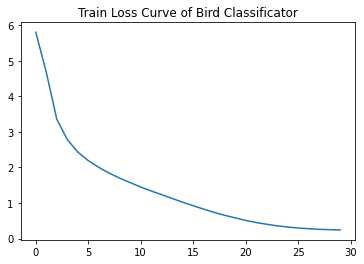

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Bird Classificator')

Text(0.5, 1.0, 'Validation Accuracy Curve of Bird Classificator')

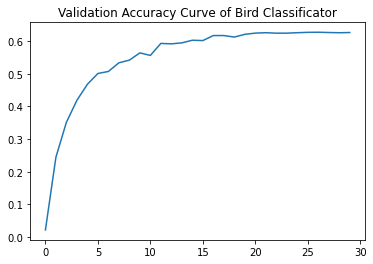

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Bird Classificator')

Text(0.5, 1.0, 'Log-score Curve of Bird Classificator')

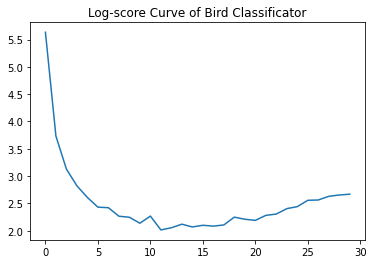

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Bird Classificator')

Text(0.5, 1.0, 'F-beta score Curve of Bird Classificator')

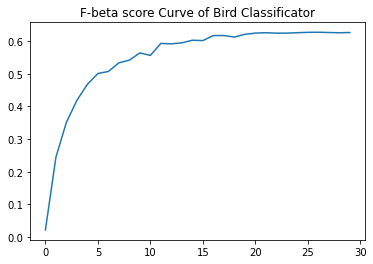

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Bird Classificator')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 62.39
Log Loss score:	2.68
Fbeta-score (beta=1.0): 	0.62
